In [1]:
!pip install torch_geometric

In [2]:
import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import torch_geometric
from torch_geometric.data import Data
import random
import timeit


from tqdm import tqdm
from sklearn import preprocessing
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, torch.__version__)
   

/Users/rozaabol/opt/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu 1.12.1


In [3]:
#!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu102.html
#!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu102.html

In [4]:
from torch_scatter import scatter_mean, scatter_add

# Defining the Attention Mechanism as a Separate Class of itself
class AttentionLayer(torch.nn.Module):
    def __init__(self, d = 16, activation=2, a = 0.1):
        """
        :param: d: Output Dimension of the Node Embeddings
        :param: activation: The Activation Function to be used for the Attention Layer
        :param: a: Slope of the -ve part if the activation is Leaky ReLU
        """
        super(AttentionLayer, self).__init__()
        self.d = d # Output dimension of the Convolution Vector for each Node
        self.activation = activation 
        self.a = a # Slope of the negative part in Leaky-ReLU
        
        self.params()
        self.initialize()
        
    def params(self):
        self.W_att = torch.nn.Parameter(torch.Tensor(self.d, self.d))

    def initialize(self):
        """
        Initialization depends upon the activation function used.
        If ReLU/ Leaky ReLU : He (Kaiming) Initialization
        If tanh/ sigmoid : Xavier Initialization
        0-ReLU, 1-Leaky ReLU, 2-tanh, 3-sigmoid
        """
        non_lin = {0:"relu", 1:"leaky_relu", 2:"tanh", 3:"sigmoid"}
        
        if (self.activation==1) or (self.activation==0):
            torch.nn.init.kaiming_normal_(self.W_att, a=self.a, nonlinearity=non_lin[self.activation])
        elif (self.activation==2) or (self.activation==3):
            torch.nn.init.xavier_normal_(self.W_att)
        else:
            raise ValueError("Activation can only take values 0,1,2,3!")

    def forward(self, node_embeddings, batch, size = None):
        """ 
        :param: node_embeddings :(N_B x D) Tensor containing Node Embeddings
        :param: batch : Tensor containing the Graph to which Each Node in the Batch belongs
        :param: size : Check Documentation https://pytorch-scatter.readthedocs.io/en/1.3.0/functions/mean.html
        :return: global_graph_embedding for each graph in the batch
        """
        size = batch[-1].item()+1 if size is None else size # Gives Batch Size = B
        
        global_context = scatter_mean(node_embeddings,index = batch, dim=0, dim_size = size) # (N_B,D) -> (B,D) (mean)
        global_context = torch.matmul(global_context, self.W_att) # (B,D) x (D,D) -> (B,D)
        
        # Applying the Non-Linearity over W_att*mean(U_i), the default is tanh
        if self.activation==2:
            global_context = torch.tanh(global_context)
        elif self.activation==1:
            leaky_relu = torch.nn.LeakyReLU()
            global_context = leaky_relu(global_context)
        elif self.activation==0:
            global_context = global_context.relu()
        elif self.activation==3:
            global_context = torch.sigmoid(global_context)
        
        # Getting the attention value for each Node for a Given Graph
        e = torch.sum(node_embeddings*global_context[batch], dim=1) # (N_B,D) * (N_B,D) -> (N_B,1) (due to sum along dimension D) 
        attn_weights = e.sigmoid() # (N_B, 1)
        
        # Calculating the Global Graph Embedding
        global_graph_embedding = scatter_add(node_embeddings*attn_weights.unsqueeze(-1),
                                             index=batch, dim=0, dim_size=size) # (N_B,D) x (N_B,1) -> (B,D)
        
        return global_graph_embedding

# **2) Neural Tensor Network Layer**

In [5]:
# Defining the Neural Tensor Network Layer as a Separate Class of Itself
class NTNLayer(torch.nn.Module):
    def __init__(self, d=16, k=16, activation=0, a = 0.1):
        """
        :param: d: Input Dimension of the NTN - i.e Dimension of the Graph/ Node Embeddings
        :param: k: Output Dimension of the NTN - No. of Similarity Scores to output
        :param: activation: Activation Function to be used for the NTN - Default = ReLU
        :param: a: Slope of the negative part for a Leaky ReLU activation
        """
        super(NTNLayer, self).__init__()
        self.d = d # Input Dimension of the NTN
        self.k = k # Output dimension of the NTN
        self.a = a # Slope in case of Leaky ReLU initialization 
        self.activation = activation
        self.params()
        self.initialize()
    
    def params(self):
        self.W = torch.nn.Parameter(torch.Tensor(self.d,self.d,self.k))
        self.V = torch.nn.Parameter(torch.Tensor(self.k, 2*self.d))
        self.b = torch.nn.Parameter(torch.Tensor(self.k,1))

    def initialize(self): 
        """
        Initialization depends upon the activation function used.
        If ReLU/ Leaky ReLU : He Initialization
        If tanh/ sigmoid : Xavier Initialization
        0-ReLU, 1-Leaky ReLU, 2-tanh, 3-sigmoid
        """
        non_lin = {0:"relu", 1:"leaky_relu", 2:"tanh", 3:"sigmoid"}
        if (self.activation==1) or (self.activation==0):
            torch.nn.init.kaiming_normal_(self.W, a=self.a, nonlinearity=non_lin[self.activation])
            torch.nn.init.kaiming_normal_(self.V, a=self.a, nonlinearity=non_lin[self.activation])
            torch.nn.init.kaiming_normal_(self.b, a=self.a, nonlinearity=non_lin[self.activation])
            
        elif (self.activation==2) or (self.activation==3):
            torch.nn.init.xavier_normal_(self.W)
            torch.nn.init.xavier_normal_(self.V)
            torch.nn.init.xavier_normal_(self.b)
        
        else:
            raise ValueError("Activation can only take values 0,1,2,3!")
        
    def forward(self, h1, h2):
        """Returns 'K' Rough Similarity Scores between the Pair of Graphs
        The Neural Tensor Network (NTN) outputs 'K' similarity scores where 'K' is a hyperparameter
        :param: h1 : Graph Embedding of Graph 1 - (B,D)
        :param: h2 : Graph Embedding of Graph 2 - (B,D)
        """
        B,_ = h1.shape
        scores = torch.mm(h1, self.W.view(self.d, -1)) # (B,D) x (D, K+D) -> (B, K+D)
        scores = scores.view(B,self.d,self.k) # (B,K+D) -> (B,D,K)
        scores = (scores*h2.unsqueeze(-1)).sum(dim=1) # (B,D,K) * (B,D,1) -> (B,K)
        
        concatenated_rep = torch.cat((h1, h2), dim=1) # (B,2D)
        scores = scores + torch.mm(concatenated_rep, self.V.t()) # (B,2D) x (2D,K) -> (B,K)
        scores = scores + self.b.t() # (B,K) + (1,K) = (B,K)
        
        if self.activation==0:
            scores = scores.relu()
            return scores
        elif self.activation==1:
            leaky_relu = torch.nn.LeakyReLU()
            scores = leaky_relu(scores)
            return scores
        elif self.activation==2:
            scores = torch.tanh(scores)
            return scores
        elif self.activation==3:
            scores = torch.sigmoid(scores)
            return scores
        else:
            raise ValueError("Activation can only take values 0,1,2,3!")

# **3) SimGNN - Putting it Together**

In [6]:
# Writing the Entire SimGNN Model
from torch_geometric.utils import to_dense_batch, to_dense_adj
from torch_geometric.nn import GCNConv
from torch.nn import Linear

class SimGNN(torch.nn.Module):
    def __init__(self, num_node_features, hist=True, ntn_layer=True, d=16, k=16, bins = 16):
        super(SimGNN, self).__init__()
        self.setupHyperParams(hist, ntn_layer, d, k, bins, num_node_features)
        self.setupLayers()
        
    def setupHyperParams(self, hist, ntn_layer, d, k, bins, num_node_features):
        self.num_node_features = num_node_features
        # Dimension of the Node/ Graph Embeddding
        self.d = d
        # Output Dimension of the NTN
        self.k = k
        # Do we want to include the NTN Layer in the pipeline
        self.ntn_layer = ntn_layer
        # Do we want to use the histogram strategy
        self.hist = hist
        # No. of Bins to be used for the Histogram 
        self.bins = bins
    
    def fcnnInputDim(self):
        """Calculate The Input Dimension of the FCNN Layer"""
        if self.hist and self.ntn_layer:
            return self.bins+self.k
        elif self.hist:
            return self.bins + 1
        elif self.ntn_layer:
            return self.k
        else : 
            # Instead of NTN ,we would just be using a simple rbf kernel
            # between the Graph Embeddings to Compute Similarities
            return 1
    
    def setupLayers(self):
        fcnn_input_dim = self.fcnnInputDim()
        
        # Layers of SimGNN
        # GCN Layers
        self.conv1 = GCNConv(self.num_node_features,64)
        self.conv2 = GCNConv(64,32)
        self.conv3 = GCNConv(32,self.d)
        
        # Attention Layer and Neural Tensor Network Layer 
        self.attention_layer = AttentionLayer(self.d)
        self.NTN = NTNLayer(self.d, self.k)
        
        # Fully Connected Layer
        self.linear_1 = torch.nn.Linear(fcnn_input_dim,16)
        self.linear_2 = torch.nn.Linear(16,8)
        self.linear_3 = torch.nn.Linear(8,4)
        self.linear_4 = torch.nn.Linear(4,1)
    
    def GCN(self, x, edge_index):
        """
        Implementing the Graph Convolutional Network
        :param x : One Hot Encoded Feature Representation of the Nodes
        :param edge_index : Tensor Representation of Edges to calculate Adjacency Matrix
        :U : (N_B x D) matrix of Node Embeddings
        :N_B : Total No. of Nodes in the Batch (irrespective of parent graph) 
        :D : dimensions of the Node Embeddings (decided by us)
        I haven't implemented Dropout/ BatchNorm but can also try to do that
        """
        U = self.conv1(x, edge_index)
        U = U.relu()
        U = self.conv2(U, edge_index)
        U = U.relu()
        U = self.conv3(U, edge_index)
        return U

    def kernel(self, graph_embedding_1, graph_embedding_2):
        pass

    def rbf_kernel_sim(self, graph_embedding_1, graph_embedding_2):
        """
        :param: graph_embedding_1 : (B,D) dimensional graph embedding
        :param: graph_embedding_2 : (B,D) dimensional graph embedding
        :return: rbf_sim : RBF Kernel Similarity the two graph embeddings
        """
        distance = graph_embedding_1-graph_embedding_2
        distance = torch.sum(distance*distance, dim = 1)
        # return (1/distance).view(-1,1)
        return torch.exp(-distance).view(-1,1)
    
    def histogram(self, U1, U2, batch1, batch2):
        """ B = Batch Size
        To calculate the Histogram Representation of the Pairwise Interaction Tensor
        :param: U1 : (N_B1 x D) matrix which encodes the node embeddings of Graph 1
        :param: U2 : (N_B2 x D) matrix which encodes the node embeddings of Graph 2
        :param: batch1 : Logs the Parent graph of the Nodes
        :param: batch2 : Logs the Parent Graph of the Nodes
        :return: norm_hist_scores : (B x self.bins) Normalized histogram for each batch
        """
        # Convert U1 and U2 into Dense Matrices
        U1, mask1 = to_dense_batch(U1, batch1) # (B, N_max1, D); (B, N_max1)
        U2, mask2 = to_dense_batch(U2, batch2) # (B, N_max2, D); (B, N_max2)
        B, N_max1, _ = U1.size()
        B, N_max2, _ = U2.size()
        
        # Max Number of Nodes for Each Graph Pair in the Batch
        max_total_nodes = torch.max(mask1.sum(dim=1), mask2.sum(dim=1)).view(-1) # (B,1)
         
        # Calculating Interaction Scores for the entire batch
        interaction_scores = torch.matmul(U1, U2.permute(0,2,1)).detach() # (B, N_max1, N_max2)
        interaction_scores = torch.sigmoid(interaction_scores)

        # Getting the Histogram for each Pair in the batch
        hist_score_list = []
        for i in range(B):
            interaction_matrix = interaction_scores[:,:max_total_nodes[i], :max_total_nodes[i]]
            hist_score = torch.histc(interaction_matrix, bins = self.bins).view(-1) # (self.bins,)
            hist_score = hist_score/hist_score.sum() # Normalizing the Histogram
            hist_score_list.append(hist_score)

        return torch.stack(hist_score_list).view(B, self.bins) # (B, self.bins)
    
    def FCNN(self, x):
        """:param: x: Rough Similarity Scores of 'B' Graph Pairs where B is Batch Size"""
        ged_sim = self.linear_1(x)
        ged_sim = ged_sim.relu()
        
        ged_sim = self.linear_2(ged_sim)
        ged_sim = ged_sim.relu()
        
        ged_sim = self.linear_3(ged_sim)
        ged_sim = ged_sim.relu()
        ged_sim = self.linear_4(ged_sim)
        
        return ged_sim.sigmoid()
    
    def forward(self, data):
        """
         Forward pass with graphs.
         :param data: A Batch Containing a Pair of Graphs.
         :return score: Similarity score.
         """
        edge_index_1 = data.edge_index_1
        edge_index_2 = data.edge_index_2
        x1, x2 = data.x1, data.x2
        x1_batch , x2_batch = data.x1_batch, data.x2_batch

        # Passed through GCN
        node_embeddings_1 = self.GCN(x1, edge_index_1)
        node_embeddings_2 = self.GCN(x2, edge_index_2)

        # Passed through Attention Layer to get Graph Embedding
        graph_embedding_1 = self.attention_layer(node_embeddings_1, x1_batch)
        graph_embedding_2 = self.attention_layer(node_embeddings_2, x2_batch)
        
        # Passed through Neural Tensor Network if allowed otherwise just take a simple Inner Product
        if self.ntn_layer:
            scores = self.NTN(graph_embedding_1, graph_embedding_2)
        else:
            scores = self.rbf_kernel_sim(graph_embedding_1, graph_embedding_2)
            
        # Computed Histogram from the Node Embeddings (Strategy 2)
        if self.hist:
            hist = self.histogram(node_embeddings_1, node_embeddings_2, x1_batch, x2_batch)
            scores = torch.cat((scores, hist), dim=1) # (B, K+self.bins)

        # Pass through the Fully Connected Neural Network Layer to get Graph Edit Distance Similarity
        sim_pred = self.FCNN(scores)
        
        return sim_pred.view(-1)

# **4) Loading Data & Feature Engineering**


## **a)Loading data**
## **b) Creating Data objects (Graphs)**

In [7]:
##***
"""In thiscode we used Car dataset. and the parameters are adjusted like GEDDataset in torch_geometric.datasets. 

List of parameters:  https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#module-torch_geometric.data
x (Tensor, optional) – Node feature matrix with shape [num_nodes, num_node_features]. (default: None)
edge_index (LongTensor, optional) – Graph connectivity in COO format with shape [2, num_edges]. (default: None)
edge_attr (Tensor, optional) – Edge feature matrix with shape [num_edges, num_edge_features]. (default: None)
y (Tensor, optional) – Graph-level or node-level ground-truth labels with arbitrary shape. (default: None)
pos (Tensor, optional) – Node position matrix with shape [num_nodes, num_dimensions]. (default: None)
"""

num_items = 10
num_nodes = num_items
num_users = 60
pr_train = 80 #percentage of number of training data
train_graphs = []
test_graphs = []
DS_graphs = []

# INFO on CAR dataset: link to download: http://users.cecs.anu.edu.au/~u4940058/CarPreferences.html
# The preference questionnaire contains control questions that were randomly selected from the preferences with reversed order. These control questions were included to measure the consistency of the answers provided. In the dataset, we include all the information collected from the experiments. The reader may choose to exclude information based on the control questions which are indicators for random responses from that user.
# Data format:The data collected from two experiments is formatted in three csv files respectively representing user attributes, item attributes, and preferences of users over items. In the preference sets for the given user, the first item (indicated by its ID) is preferred to the second one. If the preference was collected as a control question it is indicated by 1 otherwise 0.

#Original data
Dataset_users = pd.read_csv("./CarDataset/users1.csv") ##Car Dataset_Pair items
Dataset_Edges = pd.read_csv("./CarDataset/prefs1.csv") ##Car Dataset_Pair items
Dataset_Node_features = pd.read_csv("./CarDataset/items1.csv") ##Car Dataset_item features

Dataset_Node_features.drop("Item_ID", axis=1, inplace=True) #removing the index of items from the features
Nodes_FeatureMatrix = Dataset_Node_features.values.tolist()
num_node_features = len(Nodes_FeatureMatrix[0]) 
x = torch.tensor(Nodes_FeatureMatrix, dtype=torch.float) #Node feature matrix with shape [num_nodes, num_node_features]
#
old_user = 0
idx_train = 0
idx_test = 0
for index, row in Dataset_Edges.iterrows():
    current_user = row.User_ID    #CarData.User_ID[index]
    if old_user != current_user:   
        if current_user >1 and current_user <= num_users :
            # Saving graph of the user
            # Info:https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html
            edge_index = torch.tensor(Edges_matrix, dtype=torch.long) -1 #Graph connectivity in COO format with shape [2, num_edges]. (default: None)
            data = Data(edge_index=edge_index, x=x, num_nodes=num_nodes, num_features=num_node_features ) 
    
            if idx_train < num_users * (5/6): ##random.randint(0,100) < pr_train:
                train_graphs.append(data)
                DS_graphs.append(data)
                idx_train +=1
            else:
                test_graphs.append(data)  
                DS_graphs.append(data)
        # starting a new user:
        num_edges = Dataset_Edges.User_ID.tolist().count(current_user)
        Edges_matrix = np.zeros((2, num_edges)) ##empty
        edg = 0 ## edge   
    item1 = row.Item1_ID    #CarData.Item1_ID[index]
    item2 = row.Item2_ID    #CarData.Item2_ID[index]
    Edges_matrix [0][edg]= row.Item1_ID
    Edges_matrix [1][edg]= row.Item2_ID 
    edg+=1
    old_user = current_user
    
# Saving last graph user
edge_index = torch.tensor(Edges_matrix, dtype=torch.long)-1 #Graph connectivity in COO format with shape [2, num_edges]. (default: None)
data = Data(edge_index=edge_index, x=x, num_nodes=num_nodes, num_features=num_node_features ) 

test_graphs.append(data) 
DS_graphs.append(data)

In [8]:
##*** 

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

Dataset_graphs = train_graphs+ test_graphs

## **c) Creating a Feature Matrix for the Graphs**

In [9]:
from torch_geometric.transforms import OneHotDegree
from torch_geometric.utils import degree

# If the dataset does not have a feature matrix, we create one!
# Only the AIDS700nef Dataset has an inbuilt feature matrix
# We create a One Hot Encoded Degree Feature Matrix
if train_graphs[0].x is None:
            max_degree = 0
            for graph in train_graphs + test_graphs:
                # If this graph has edges then do
                if graph.edge_index.size(1) > 0:
                    max_degree = max(max_degree, int(degree(graph.edge_index[0]).max().item()))
            
            # Create the feature matrix for the Dataset
            one_hot_degree = OneHotDegree(max_degree, cat=False)
            train_graphs.transform = one_hot_degree
            test_graphs.transform = one_hot_degree

num_node_features = train_graphs[0].num_features ##**
num_edge_features = train_graphs[0].num_edge_features ##**
print(num_node_features, num_edge_features)

4 0


## **d) Similarity between the praphs**

In [10]:
## **Similarity**  A function which takes two inputs and returns theis similarity as a number.
# In "Recommendation systems", one measure for similarity between two users is to find the distance between their top-k most prefered items

# Item_scores_matrix is a matrix which rows are users and columns are items. Entries indicte how much the user likes this item more than the other items.
Item_scores_matrix = np.zeros((num_users, num_items))
for index, row in Dataset_Edges.iterrows():
    user = row.User_ID    #CarData.User_ID[index] 
    item1 = row.Item1_ID    #CarData.Item1_ID[index]
    item2 = row.Item2_ID    #CarData.Item2_ID[index]
    Item_scores_matrix[user-1][item1-1] += 1

    
# Normalizing the scores
Personalized_Item_scores_matrix = np.zeros((num_users, num_items))
for user in range(num_users):       
    Personalized_Item_scores_matrix[user] = Item_scores_matrix[user]/ (num_items)




## **e) Making Pairs of Graphs**

In [11]:
class makeGraphPairs(torch_geometric.data.Data):
    """ 
    :param: edge_index_1 : Edge Index of the First Graph
    :param: edge_index_2 : Edge Index of the Second Graph in the pair
    :param: x_1 : Feature Matrix of the First Graph in the Pair
    :param: x_2 : Feature Matrix of the Second Graph in the Pair
       
    :returns: torch_geometric.data.Data object which comprises two graphs
    """
    def __init__(self, edge_index_1, x1, edge_index_2, x2, graph_sim):#, ged, norm_ged):##**
        super(makeGraphPairs, self).__init__()
        self.edge_index_1 = edge_index_1
        self.x1 = x1
        self.edge_index_2 = edge_index_2
        self.x2 = x2
        #self.ged = ged ##*
        #self.norm_ged = norm_ged ##*
        self.graph_sim = graph_sim ##*
               
    
    def __inc__(self, key, value,*rest): ## I added *rest
        if key == "edge_index_1":
            return self.x1.size(0)
        elif key == "edge_index_2":
            return self.x2.size(0)
        else:
            return super().__inc__(key, value)## I added *rest

In [12]:
 ## **Similarity**  A function which takes two inputs and returns their similarity as a number.
 # Here, similarity is the intersect of top ranled items for two users.

def sim_TopK (x, y):  
    #Indices1 = (-Personalized_Item_scores_matrix[user1.idx]).argsort()[:3] # Index of 3-best items (Culd use this one as well.)
    Personalized_Item_scores1 = np.zeros((num_items))
    Personalized_Item_scores2 = np.zeros((num_items))
    for item in range(num_items):  
        Personalized_Item_scores1[item] =  x[0].tolist().count(item)/num_items # Personalized item score: (How many times i item prefered / num_items)
        Personalized_Item_scores2[item] =  y[0].tolist().count(item)/num_items  
    # number of items with score more than n:
    n = 0.2
    Indices1 = [i for i,v in enumerate(Personalized_Item_scores1) if v >= n]
    Indices2 = [j for j,h in enumerate(Personalized_Item_scores2) if h >= n]
    graph_sim = len(np.intersect1d(Indices1,Indices2))/((len(Indices1)+len(Indices2))/2) #Min-max normalization on number of intersection of the preferences
    return graph_sim


In [13]:
 ## **Similarity**  A function which takes two inputs and returns theis similarity as a number.
 # Here, similarity is the intersect of top ranled items for two users.

def sim_GED (x, y):  
    # Number of similar edges
    x_pairs = list(zip(x[0],x[1]))
    y_pairs = list(zip(y[0],y[1]))


    graph_sim = len([l for l in x_pairs if l in y_pairs]) /(np.max([len(x_pairs), len(y_pairs)]))
    return graph_sim    



### **i. For Training**

In [14]:
"""TRAINING SET PAIR"""
# Data List to pass into the Data Loader to get Batches
train_graph_pair_list = []


# Making the Pairs of Graphs
for graph1_num, graph1 in enumerate(train_graphs):
    for graph2 in train_graphs:
        # Initializing Data
        edge_index_1 = graph1.edge_index
        x1 = graph1.x
        edge_index_2 = graph2.edge_index
        x2 = graph2.x

        graph_sim =  sim_TopK (edge_index_1, edge_index_2)  ##**
        
        # Making Graph Pair
        graph_pair = makeGraphPairs(edge_index_1=edge_index_1, x1=x1, 
                                    edge_index_2=edge_index_2, x2=x2, graph_sim = graph_sim)#,ged=ged ,norm_ged=norm_ged , graph_sim = graph_sim) ##*
        
        # Saving all the Graph Pairs to the List for Batching and Data Loading
        train_graph_pair_list.append(graph_pair)

### **ii. For Testing**

In [15]:
"""TEST SET PAIR"""
# Data List to pass into the Data Loader to get batches
test_graph_pair_list = []

# Making the Pairs of Graphs

for graph1 in test_graphs:
    for graph2 in train_graphs:
        # Initializing Data
        edge_index_1 = graph1.edge_index
        x1 = graph1.x
        edge_index_2 = graph2.edge_index
        x2 = graph2.x
        
        graph_sim =  sim_TopK (edge_index_1, edge_index_2)  ##**
        
        # Making Graph Pair
        graph_pair = makeGraphPairs(edge_index_1=edge_index_1, x1=x1, 
                                    edge_index_2=edge_index_2, x2=x2, graph_sim = graph_sim)#, ged=ged ,norm_ged=norm_ged)
        
        # Saving all the Graph Pairs to the List for Batching and Data Loading
        test_graph_pair_list.append(graph_pair)


In [16]:
"""Whole Data SET PAIR"""
# Data List to pass into the Data Loader to get Batches
Dataset_graph_pair_list = []


# Making the Pairs of Graphs
for graph1_num, graph1 in enumerate(DS_graphs):
    for graph2 in DS_graphs:
        # Initializing Data
        edge_index_1 = graph1.edge_index
        x1 = graph1.x
        edge_index_2 = graph2.edge_index
        x2 = graph2.x

        graph_sim =  sim_TopK (edge_index_1, edge_index_2)  ##**
        
        # Making Graph Pair
        graph_pair = makeGraphPairs(edge_index_1=edge_index_1, x1=x1, 
                                    edge_index_2=edge_index_2, x2=x2, graph_sim = graph_sim)#,ged=ged ,norm_ged=norm_ged , graph_sim = graph_sim) ##*
        
        # Saving all the Graph Pairs to the List for Batching and Data Loading
        Dataset_graph_pair_list.append(graph_pair)        
        
        
               
        

# **5) Training Begins**

In [17]:
import random

# Creating Validation Data
val_graph_pair_list = random.sample(train_graph_pair_list, len(test_graph_pair_list))
# Removing the Validation examples from Train Set
#train_graph_pair_list = list(set(train_graph_pair_list)-set(val_graph_pair_list))
train_graph_pair_list = [x for x in train_graph_pair_list if x not in val_graph_pair_list] ##

print("Number of Training Graph Pairs = {}".format(len(train_graph_pair_list)))
print("Number of Validation Graph Pairs = {}".format(len(val_graph_pair_list)))
print("Number of Test Graph Pairs = {}".format(len(test_graph_pair_list)))
print("Number of Dataset Graph Pairs = {}".format(len(Dataset_graph_pair_list)))


Number of Training Graph Pairs = 2000
Number of Validation Graph Pairs = 500
Number of Test Graph Pairs = 500
Number of Dataset Graph Pairs = 3600


In [18]:

batch_size = 128
bs =  128

train_loader = DataLoader(train_graph_pair_list, batch_size = batch_size, follow_batch = ["x1", "x2"], shuffle = True)
val_loader = DataLoader(val_graph_pair_list, batch_size = batch_size, follow_batch= ["x1", "x2"], shuffle = True)
test_loader = DataLoader(test_graph_pair_list, batch_size = bs, follow_batch = ["x1", "x2"], shuffle = True)
Dataset_loader = DataLoader(Dataset_graph_pair_list, batch_size = 1, follow_batch = ["x1", "x2"], shuffle = True)


In [19]:
def evaluate(dataloader, model, loss_criterion):
    total_loss = 0
    num_ex = 0
    model.eval()
    predicted_sim = [] ##** predicted similarity
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            sim_pred = model(data)
            predicted_sim.append(sim_pred.tolist())   ##**
            batch_loss = loss_criterion(sim_pred , data.graph_sim)
            total_loss = total_loss + batch_loss # *len(data.ged) ##**
            num_ex += 1#len(data.ged)  ##**

            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
    return total_loss.item()/num_ex ,predicted_sim ##**

In [20]:
print ("Training in process...")

model = SimGNN(num_node_features, ntn_layer=True, hist=True).to(device)
loss_criterion = torch.nn.MSELoss()
lr = 0.0001
opt = torch.optim.AdamW(model.parameters(), lr = lr, weight_decay = 5e-6)

epochs = 100
min_val_loss = 1000
min_train_loss = 0
num_batches = len(train_loader) 


import time
import copy
from itertools import cycle
train_loss_arr = []
val_loss_arr = []
tik = time.time()

for epoch in tqdm(range(epochs), desc="Epochs"):
    print (epoch, "/",epochs)
    model.train()
    for i,(train_batch, val_batch) in enumerate(zip(train_loader, cycle(val_loader))):
        # Training the Model
        opt.zero_grad()
        train_batch = train_batch.to(device)
        y_pred = model(train_batch)
        label = torch.tensor(train_batch.graph_sim, dtype=torch.float)
        loss = loss_criterion(y_pred.view(-1), label)
        loss.backward()
        opt.step()
        train_loss_arr.append(loss.item())

        #Cross Validation Begins
        model.eval()
        with torch.no_grad():
            val_batch = val_batch.to(device)
            y_val_pred = model(val_batch)
            val_loss = loss_criterion(y_val_pred.view(-1), val_batch.graph_sim)
            val_loss_arr.append(val_loss.item())
        model.train()
        
        # Model Checkpointing
        if (min_val_loss>loss.item()) and (min_val_loss>val_loss.item()):
            min_val_loss = val_loss.item()
            min_train_loss = loss.item() # Just saving this for reference
            best_model = copy.deepcopy(model.state_dict())
        
        # Printing Loss Values
        if i%200 == 0:
            print(f"Epoch{epoch+1}/{epochs} | Batch: {i}/{num_batches} | Train Loss: {loss} | Validation Loss: {val_loss}")
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache() 
            
    
    
    # Printing Epoch Summary
    print(f"Epoch: {epoch+1}/{epochs} | Train MSE: {loss} | Validation MSE: {val_loss}")
    

    
tok = time.time()

Training in process...


Epochs:   0%|                                           | 0/100 [00:00<?, ?it/s]

0 / 100
Epoch1/100 | Batch: 0/16 | Train Loss: 0.06710189580917358 | Validation Loss: 0.06814052164554596


/var/folders/3n/n3f4n2gn3hg1xvkglkjfg8wh0000gq/T/ipykernel_21799/4108353566.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(train_batch.graph_sim, dtype=torch.float)
Epochs:   1%|▎                                  | 1/100 [00:00<01:27,  1.13it/s]

Epoch: 1/100 | Train MSE: 0.03456136956810951 | Validation MSE: 0.034196093678474426
1 / 100
Epoch2/100 | Batch: 0/16 | Train Loss: 0.03277943283319473 | Validation Loss: 0.02971607632935047


Epochs:   2%|▋                                  | 2/100 [00:01<01:23,  1.18it/s]

Epoch: 2/100 | Train MSE: 0.011209103278815746 | Validation MSE: 0.008645158261060715
2 / 100
Epoch3/100 | Batch: 0/16 | Train Loss: 0.00894206203520298 | Validation Loss: 0.010251721367239952


Epochs:   3%|█                                  | 3/100 [00:02<01:20,  1.21it/s]

Epoch: 3/100 | Train MSE: 0.007982367649674416 | Validation MSE: 0.007685917895287275
3 / 100
Epoch4/100 | Batch: 0/16 | Train Loss: 0.010420694947242737 | Validation Loss: 0.008481979370117188


Epochs:   4%|█▍                                 | 4/100 [00:03<01:18,  1.22it/s]

Epoch: 4/100 | Train MSE: 0.007936099544167519 | Validation MSE: 0.007666444405913353
4 / 100
Epoch5/100 | Batch: 0/16 | Train Loss: 0.01024322584271431 | Validation Loss: 0.006826787255704403


Epochs:   5%|█▊                                 | 5/100 [00:04<01:18,  1.21it/s]

Epoch: 5/100 | Train MSE: 0.008998431265354156 | Validation MSE: 0.007723194546997547
5 / 100
Epoch6/100 | Batch: 0/16 | Train Loss: 0.009254827164113522 | Validation Loss: 0.006990401074290276


Epochs:   6%|██                                 | 6/100 [00:04<01:17,  1.21it/s]

Epoch: 6/100 | Train MSE: 0.008237633854150772 | Validation MSE: 0.007206140086054802
6 / 100
Epoch7/100 | Batch: 0/16 | Train Loss: 0.008028912357985973 | Validation Loss: 0.006956659257411957


Epochs:   7%|██▍                                | 7/100 [00:05<01:16,  1.22it/s]

Epoch: 7/100 | Train MSE: 0.006816026754677296 | Validation MSE: 0.006057231221348047
7 / 100
Epoch8/100 | Batch: 0/16 | Train Loss: 0.008926778100430965 | Validation Loss: 0.007405857555568218


Epochs:   8%|██▊                                | 8/100 [00:06<01:16,  1.21it/s]

Epoch: 8/100 | Train MSE: 0.0058123208582401276 | Validation MSE: 0.006434943526983261
8 / 100
Epoch9/100 | Batch: 0/16 | Train Loss: 0.007388733327388763 | Validation Loss: 0.006826619617640972


Epochs:   9%|███▏                               | 9/100 [00:07<01:16,  1.19it/s]

Epoch: 9/100 | Train MSE: 0.008182431571185589 | Validation MSE: 0.005964294541627169
9 / 100
Epoch10/100 | Batch: 0/16 | Train Loss: 0.007611884735524654 | Validation Loss: 0.005839427467435598


Epochs:  10%|███▍                              | 10/100 [00:08<01:15,  1.19it/s]

Epoch: 10/100 | Train MSE: 0.006826254539191723 | Validation MSE: 0.006562631577253342
10 / 100
Epoch11/100 | Batch: 0/16 | Train Loss: 0.007048401050269604 | Validation Loss: 0.006382648833096027


Epochs:  11%|███▋                              | 11/100 [00:09<01:14,  1.20it/s]

Epoch: 11/100 | Train MSE: 0.007427810691297054 | Validation MSE: 0.006818033289164305
11 / 100
Epoch12/100 | Batch: 0/16 | Train Loss: 0.006142140366137028 | Validation Loss: 0.006128794047981501


Epochs:  12%|████                              | 12/100 [00:09<01:13,  1.20it/s]

Epoch: 12/100 | Train MSE: 0.007168478332459927 | Validation MSE: 0.006049692630767822
12 / 100
Epoch13/100 | Batch: 0/16 | Train Loss: 0.007943643257021904 | Validation Loss: 0.005830211099237204


Epochs:  13%|████▍                             | 13/100 [00:10<01:12,  1.20it/s]

Epoch: 13/100 | Train MSE: 0.005965950898826122 | Validation MSE: 0.005574158392846584
13 / 100
Epoch14/100 | Batch: 0/16 | Train Loss: 0.006822813302278519 | Validation Loss: 0.0045052096247673035


Epochs:  14%|████▊                             | 14/100 [00:11<01:11,  1.20it/s]

Epoch: 14/100 | Train MSE: 0.006190541200339794 | Validation MSE: 0.0062142424285411835
14 / 100
Epoch15/100 | Batch: 0/16 | Train Loss: 0.006020849570631981 | Validation Loss: 0.004581985529512167


Epochs:  15%|█████                             | 15/100 [00:12<01:10,  1.21it/s]

Epoch: 15/100 | Train MSE: 0.006088304333388805 | Validation MSE: 0.0059966337867081165
15 / 100
Epoch16/100 | Batch: 0/16 | Train Loss: 0.00583614269271493 | Validation Loss: 0.0059624891728162766


Epochs:  16%|█████▍                            | 16/100 [00:13<01:13,  1.14it/s]

Epoch: 16/100 | Train MSE: 0.004790159873664379 | Validation MSE: 0.00454490352421999
16 / 100
Epoch17/100 | Batch: 0/16 | Train Loss: 0.007110719569027424 | Validation Loss: 0.004901735112071037


Epochs:  17%|█████▊                            | 17/100 [00:14<01:13,  1.13it/s]

Epoch: 17/100 | Train MSE: 0.006064091343432665 | Validation MSE: 0.004786431789398193
17 / 100
Epoch18/100 | Batch: 0/16 | Train Loss: 0.006058379542082548 | Validation Loss: 0.005335840862244368


Epochs:  18%|██████                            | 18/100 [00:15<01:12,  1.13it/s]

Epoch: 18/100 | Train MSE: 0.0062688859179615974 | Validation MSE: 0.004314512480050325
18 / 100
Epoch19/100 | Batch: 0/16 | Train Loss: 0.005327170714735985 | Validation Loss: 0.0061133308336138725


Epochs:  19%|██████▍                           | 19/100 [00:16<01:10,  1.15it/s]

Epoch: 19/100 | Train MSE: 0.0057649631053209305 | Validation MSE: 0.005191481206566095
19 / 100
Epoch20/100 | Batch: 0/16 | Train Loss: 0.00566387502476573 | Validation Loss: 0.004542316310107708


Epochs:  20%|██████▊                           | 20/100 [00:17<01:15,  1.06it/s]

Epoch: 20/100 | Train MSE: 0.005217597354203463 | Validation MSE: 0.004500519949942827
20 / 100
Epoch21/100 | Batch: 0/16 | Train Loss: 0.004617561586201191 | Validation Loss: 0.0048713404685258865


Epochs:  21%|███████▏                          | 21/100 [00:18<01:11,  1.10it/s]

Epoch: 21/100 | Train MSE: 0.0049933032132685184 | Validation MSE: 0.0041596549563109875
21 / 100
Epoch22/100 | Batch: 0/16 | Train Loss: 0.005248368717730045 | Validation Loss: 0.005073442589491606


Epochs:  22%|███████▍                          | 22/100 [00:18<01:09,  1.12it/s]

Epoch: 22/100 | Train MSE: 0.0055716997012495995 | Validation MSE: 0.0035553970374166965
22 / 100
Epoch23/100 | Batch: 0/16 | Train Loss: 0.0059478264302015305 | Validation Loss: 0.004293044563382864


Epochs:  23%|███████▊                          | 23/100 [00:19<01:08,  1.13it/s]

Epoch: 23/100 | Train MSE: 0.0045105270110070705 | Validation MSE: 0.00427628867328167
23 / 100
Epoch24/100 | Batch: 0/16 | Train Loss: 0.004615757614374161 | Validation Loss: 0.0048339650966227055


Epochs:  24%|████████▏                         | 24/100 [00:20<01:06,  1.15it/s]

Epoch: 24/100 | Train MSE: 0.005256129894405603 | Validation MSE: 0.0034857746213674545
24 / 100
Epoch25/100 | Batch: 0/16 | Train Loss: 0.004993179813027382 | Validation Loss: 0.004793688654899597


Epochs:  25%|████████▌                         | 25/100 [00:21<01:05,  1.15it/s]

Epoch: 25/100 | Train MSE: 0.004360283724963665 | Validation MSE: 0.004282630048692226
25 / 100
Epoch26/100 | Batch: 0/16 | Train Loss: 0.004800552502274513 | Validation Loss: 0.004055595491081476


Epochs:  26%|████████▊                         | 26/100 [00:22<01:03,  1.16it/s]

Epoch: 26/100 | Train MSE: 0.0049680001102387905 | Validation MSE: 0.002961752936244011
26 / 100
Epoch27/100 | Batch: 0/16 | Train Loss: 0.004683451261371374 | Validation Loss: 0.0035023896489292383


Epochs:  27%|█████████▏                        | 27/100 [00:23<01:02,  1.16it/s]

Epoch: 27/100 | Train MSE: 0.005079390946775675 | Validation MSE: 0.0037535487208515406
27 / 100
Epoch28/100 | Batch: 0/16 | Train Loss: 0.004836742766201496 | Validation Loss: 0.004325924441218376


Epochs:  28%|█████████▌                        | 28/100 [00:23<01:01,  1.18it/s]

Epoch: 28/100 | Train MSE: 0.00600004056468606 | Validation MSE: 0.0050640227273106575
28 / 100
Epoch29/100 | Batch: 0/16 | Train Loss: 0.005332286935299635 | Validation Loss: 0.004132016561925411


Epochs:  29%|█████████▊                        | 29/100 [00:24<01:00,  1.17it/s]

Epoch: 29/100 | Train MSE: 0.003484622808173299 | Validation MSE: 0.004066992551088333
29 / 100
Epoch30/100 | Batch: 0/16 | Train Loss: 0.005003607831895351 | Validation Loss: 0.004100407008081675


Epochs:  30%|██████████▏                       | 30/100 [00:25<01:03,  1.11it/s]

Epoch: 30/100 | Train MSE: 0.0040392279624938965 | Validation MSE: 0.004151729866862297
30 / 100
Epoch31/100 | Batch: 0/16 | Train Loss: 0.004629291128367186 | Validation Loss: 0.004098143428564072


Epochs:  31%|██████████▌                       | 31/100 [00:26<01:01,  1.12it/s]

Epoch: 31/100 | Train MSE: 0.0037344847805798054 | Validation MSE: 0.004217947367578745
31 / 100
Epoch32/100 | Batch: 0/16 | Train Loss: 0.004626934416592121 | Validation Loss: 0.003949182573705912


Epochs:  32%|██████████▉                       | 32/100 [00:27<00:59,  1.15it/s]

Epoch: 32/100 | Train MSE: 0.004780665505677462 | Validation MSE: 0.003735924605280161
32 / 100
Epoch33/100 | Batch: 0/16 | Train Loss: 0.004015353973954916 | Validation Loss: 0.003759469371289015


Epochs:  33%|███████████▏                      | 33/100 [00:28<00:57,  1.16it/s]

Epoch: 33/100 | Train MSE: 0.003638672409579158 | Validation MSE: 0.003426512936130166
33 / 100
Epoch34/100 | Batch: 0/16 | Train Loss: 0.004451289307326078 | Validation Loss: 0.004091962240636349


Epochs:  34%|███████████▌                      | 34/100 [00:29<00:55,  1.18it/s]

Epoch: 34/100 | Train MSE: 0.0049658301286399364 | Validation MSE: 0.003935487009584904
34 / 100
Epoch35/100 | Batch: 0/16 | Train Loss: 0.0044815437868237495 | Validation Loss: 0.0032480242662131786


Epochs:  35%|███████████▉                      | 35/100 [00:30<00:54,  1.20it/s]

Epoch: 35/100 | Train MSE: 0.004893489181995392 | Validation MSE: 0.0039628432132303715
35 / 100
Epoch36/100 | Batch: 0/16 | Train Loss: 0.004344280809164047 | Validation Loss: 0.004191336687654257


Epochs:  36%|████████████▏                     | 36/100 [00:30<00:53,  1.19it/s]

Epoch: 36/100 | Train MSE: 0.004607715643942356 | Validation MSE: 0.0028037724550813437
36 / 100
Epoch37/100 | Batch: 0/16 | Train Loss: 0.004457049071788788 | Validation Loss: 0.003584552090615034


Epochs:  37%|████████████▌                     | 37/100 [00:31<00:52,  1.20it/s]

Epoch: 37/100 | Train MSE: 0.0044769058004021645 | Validation MSE: 0.004187299869954586
37 / 100
Epoch38/100 | Batch: 0/16 | Train Loss: 0.004061685875058174 | Validation Loss: 0.0033272935543209314


Epochs:  38%|████████████▉                     | 38/100 [00:32<00:50,  1.23it/s]

Epoch: 38/100 | Train MSE: 0.003975815139710903 | Validation MSE: 0.0036530261859297752
38 / 100
Epoch39/100 | Batch: 0/16 | Train Loss: 0.003818740602582693 | Validation Loss: 0.0028420002199709415


Epochs:  39%|█████████████▎                    | 39/100 [00:33<00:49,  1.24it/s]

Epoch: 39/100 | Train MSE: 0.0034336044918745756 | Validation MSE: 0.0034828712232410908
39 / 100
Epoch40/100 | Batch: 0/16 | Train Loss: 0.003875811817124486 | Validation Loss: 0.003527470864355564


Epochs:  40%|█████████████▌                    | 40/100 [00:34<00:48,  1.24it/s]

Epoch: 40/100 | Train MSE: 0.004217385780066252 | Validation MSE: 0.0032459788490086794
40 / 100
Epoch41/100 | Batch: 0/16 | Train Loss: 0.0039000562392175198 | Validation Loss: 0.003128174925222993


Epochs:  41%|█████████████▉                    | 41/100 [00:34<00:47,  1.24it/s]

Epoch: 41/100 | Train MSE: 0.004000208806246519 | Validation MSE: 0.003023899393156171
41 / 100
Epoch42/100 | Batch: 0/16 | Train Loss: 0.0039050239138305187 | Validation Loss: 0.003517952049151063


Epochs:  42%|██████████████▎                   | 42/100 [00:35<00:47,  1.23it/s]

Epoch: 42/100 | Train MSE: 0.005084062926471233 | Validation MSE: 0.0036099383141845465
42 / 100
Epoch43/100 | Batch: 0/16 | Train Loss: 0.004143578000366688 | Validation Loss: 0.00402279244735837


Epochs:  43%|██████████████▌                   | 43/100 [00:36<00:46,  1.23it/s]

Epoch: 43/100 | Train MSE: 0.004168589599430561 | Validation MSE: 0.003449414623901248
43 / 100
Epoch44/100 | Batch: 0/16 | Train Loss: 0.003751723561435938 | Validation Loss: 0.003395198378711939


Epochs:  44%|██████████████▉                   | 44/100 [00:37<00:45,  1.23it/s]

Epoch: 44/100 | Train MSE: 0.003978903871029615 | Validation MSE: 0.003725682385265827
44 / 100
Epoch45/100 | Batch: 0/16 | Train Loss: 0.004279244691133499 | Validation Loss: 0.003236012766137719


Epochs:  45%|███████████████▎                  | 45/100 [00:38<00:45,  1.21it/s]

Epoch: 45/100 | Train MSE: 0.0036928504705429077 | Validation MSE: 0.004015188664197922
45 / 100
Epoch46/100 | Batch: 0/16 | Train Loss: 0.0042022112756967545 | Validation Loss: 0.003951575141400099


Epochs:  46%|███████████████▋                  | 46/100 [00:38<00:44,  1.21it/s]

Epoch: 46/100 | Train MSE: 0.004336508456617594 | Validation MSE: 0.003084305441007018
46 / 100
Epoch47/100 | Batch: 0/16 | Train Loss: 0.003937374334782362 | Validation Loss: 0.003019695868715644


Epochs:  47%|███████████████▉                  | 47/100 [00:39<00:43,  1.22it/s]

Epoch: 47/100 | Train MSE: 0.004630412440747023 | Validation MSE: 0.003317980095744133
47 / 100
Epoch48/100 | Batch: 0/16 | Train Loss: 0.0035573069471865892 | Validation Loss: 0.003439972409978509


Epochs:  48%|████████████████▎                 | 48/100 [00:40<00:42,  1.23it/s]

Epoch: 48/100 | Train MSE: 0.0034843150060623884 | Validation MSE: 0.0030327290296554565
48 / 100
Epoch49/100 | Batch: 0/16 | Train Loss: 0.003840541932731867 | Validation Loss: 0.0034087556414306164


Epochs:  49%|████████████████▋                 | 49/100 [00:41<00:41,  1.22it/s]

Epoch: 49/100 | Train MSE: 0.003666236996650696 | Validation MSE: 0.0040620602667331696
49 / 100
Epoch50/100 | Batch: 0/16 | Train Loss: 0.0036417138762772083 | Validation Loss: 0.002959874225780368


Epochs:  50%|█████████████████                 | 50/100 [00:42<00:40,  1.23it/s]

Epoch: 50/100 | Train MSE: 0.003518246114253998 | Validation MSE: 0.004043093416839838
50 / 100
Epoch51/100 | Batch: 0/16 | Train Loss: 0.0031455829739570618 | Validation Loss: 0.0038573662750422955


Epochs:  51%|█████████████████▎                | 51/100 [00:43<00:39,  1.24it/s]

Epoch: 51/100 | Train MSE: 0.004204418510198593 | Validation MSE: 0.0037287070881575346
51 / 100
Epoch52/100 | Batch: 0/16 | Train Loss: 0.0036312013398855925 | Validation Loss: 0.0032211760990321636


Epochs:  52%|█████████████████▋                | 52/100 [00:43<00:39,  1.23it/s]

Epoch: 52/100 | Train MSE: 0.0036813162732869387 | Validation MSE: 0.002812816994264722
52 / 100
Epoch53/100 | Batch: 0/16 | Train Loss: 0.0037577408365905285 | Validation Loss: 0.003825632156804204


Epochs:  53%|██████████████████                | 53/100 [00:44<00:38,  1.23it/s]

Epoch: 53/100 | Train MSE: 0.00408845953643322 | Validation MSE: 0.00402139313519001
53 / 100
Epoch54/100 | Batch: 0/16 | Train Loss: 0.0033071483485400677 | Validation Loss: 0.002804227638989687


Epochs:  54%|██████████████████▎               | 54/100 [00:45<00:37,  1.23it/s]

Epoch: 54/100 | Train MSE: 0.0029663925524801016 | Validation MSE: 0.003488953458145261
54 / 100
Epoch55/100 | Batch: 0/16 | Train Loss: 0.003644963726401329 | Validation Loss: 0.003230476286262274


Epochs:  55%|██████████████████▋               | 55/100 [00:46<00:36,  1.23it/s]

Epoch: 55/100 | Train MSE: 0.004101641476154327 | Validation MSE: 0.0037991234567016363
55 / 100
Epoch56/100 | Batch: 0/16 | Train Loss: 0.003577467054128647 | Validation Loss: 0.0035184952430427074


Epochs:  56%|███████████████████               | 56/100 [00:47<00:35,  1.24it/s]

Epoch: 56/100 | Train MSE: 0.004297709558159113 | Validation MSE: 0.0027856584638357162
56 / 100
Epoch57/100 | Batch: 0/16 | Train Loss: 0.004128565546125174 | Validation Loss: 0.003508779453113675


Epochs:  57%|███████████████████▍              | 57/100 [00:47<00:34,  1.24it/s]

Epoch: 57/100 | Train MSE: 0.004046139772981405 | Validation MSE: 0.002873615361750126
57 / 100
Epoch58/100 | Batch: 0/16 | Train Loss: 0.0038275327533483505 | Validation Loss: 0.0033599042799323797


Epochs:  58%|███████████████████▋              | 58/100 [00:48<00:33,  1.24it/s]

Epoch: 58/100 | Train MSE: 0.003893684595823288 | Validation MSE: 0.0028303239960223436
58 / 100
Epoch59/100 | Batch: 0/16 | Train Loss: 0.0036875642836093903 | Validation Loss: 0.003888933453708887


Epochs:  59%|████████████████████              | 59/100 [00:49<00:33,  1.24it/s]

Epoch: 59/100 | Train MSE: 0.003942550625652075 | Validation MSE: 0.0028854859992861748
59 / 100
Epoch60/100 | Batch: 0/16 | Train Loss: 0.0039508044719696045 | Validation Loss: 0.0030173673294484615


Epochs:  60%|████████████████████▍             | 60/100 [00:50<00:32,  1.23it/s]

Epoch: 60/100 | Train MSE: 0.0035396087914705276 | Validation MSE: 0.003366991179063916
60 / 100
Epoch61/100 | Batch: 0/16 | Train Loss: 0.0037117023020982742 | Validation Loss: 0.002708977786824107


Epochs:  61%|████████████████████▋             | 61/100 [00:51<00:31,  1.23it/s]

Epoch: 61/100 | Train MSE: 0.0031218614894896746 | Validation MSE: 0.0029056004714220762
61 / 100
Epoch62/100 | Batch: 0/16 | Train Loss: 0.0032838983461260796 | Validation Loss: 0.002621290273964405


Epochs:  62%|█████████████████████             | 62/100 [00:51<00:30,  1.24it/s]

Epoch: 62/100 | Train MSE: 0.004111523739993572 | Validation MSE: 0.0033377965446561575
62 / 100
Epoch63/100 | Batch: 0/16 | Train Loss: 0.003623821772634983 | Validation Loss: 0.0034624424297362566


Epochs:  63%|█████████████████████▍            | 63/100 [00:52<00:30,  1.23it/s]

Epoch: 63/100 | Train MSE: 0.0033041327260434628 | Validation MSE: 0.003374330932274461
63 / 100
Epoch64/100 | Batch: 0/16 | Train Loss: 0.003935458604246378 | Validation Loss: 0.0032321219332516193


Epochs:  64%|█████████████████████▊            | 64/100 [00:53<00:29,  1.23it/s]

Epoch: 64/100 | Train MSE: 0.003045483026653528 | Validation MSE: 0.0030338449869304895
64 / 100
Epoch65/100 | Batch: 0/16 | Train Loss: 0.004160095471888781 | Validation Loss: 0.003810941008850932


Epochs:  65%|██████████████████████            | 65/100 [00:54<00:28,  1.23it/s]

Epoch: 65/100 | Train MSE: 0.0035525313578546047 | Validation MSE: 0.002923283027485013
65 / 100
Epoch66/100 | Batch: 0/16 | Train Loss: 0.00413668854162097 | Validation Loss: 0.0033907638862729073


Epochs:  66%|██████████████████████▍           | 66/100 [00:55<00:27,  1.23it/s]

Epoch: 66/100 | Train MSE: 0.0028573914896696806 | Validation MSE: 0.0035316050052642822
66 / 100
Epoch67/100 | Batch: 0/16 | Train Loss: 0.003880755277350545 | Validation Loss: 0.003016160801053047


Epochs:  67%|██████████████████████▊           | 67/100 [00:56<00:27,  1.22it/s]

Epoch: 67/100 | Train MSE: 0.0030879038386046886 | Validation MSE: 0.002656724536791444
67 / 100
Epoch68/100 | Batch: 0/16 | Train Loss: 0.004037374164909124 | Validation Loss: 0.0024558175355196


Epochs:  68%|███████████████████████           | 68/100 [00:56<00:26,  1.22it/s]

Epoch: 68/100 | Train MSE: 0.004446336533874273 | Validation MSE: 0.003907294012606144
68 / 100
Epoch69/100 | Batch: 0/16 | Train Loss: 0.0035418858751654625 | Validation Loss: 0.0031961495988070965


Epochs:  69%|███████████████████████▍          | 69/100 [00:57<00:25,  1.22it/s]

Epoch: 69/100 | Train MSE: 0.003214741125702858 | Validation MSE: 0.0029674372635781765
69 / 100
Epoch70/100 | Batch: 0/16 | Train Loss: 0.003443365916609764 | Validation Loss: 0.0038107919972389936


Epochs:  70%|███████████████████████▊          | 70/100 [00:58<00:24,  1.22it/s]

Epoch: 70/100 | Train MSE: 0.003634382039308548 | Validation MSE: 0.0029404168017208576
70 / 100
Epoch71/100 | Batch: 0/16 | Train Loss: 0.0030446150340139866 | Validation Loss: 0.003103291615843773


Epochs:  71%|████████████████████████▏         | 71/100 [00:59<00:23,  1.22it/s]

Epoch: 71/100 | Train MSE: 0.0032920478843152523 | Validation MSE: 0.0029663376044481993
71 / 100
Epoch72/100 | Batch: 0/16 | Train Loss: 0.003729137359187007 | Validation Loss: 0.0030009320471435785


Epochs:  72%|████████████████████████▍         | 72/100 [01:00<00:22,  1.23it/s]

Epoch: 72/100 | Train MSE: 0.004163958132266998 | Validation MSE: 0.002913114381954074
72 / 100
Epoch73/100 | Batch: 0/16 | Train Loss: 0.0037128091789782047 | Validation Loss: 0.002824540250003338


Epochs:  73%|████████████████████████▊         | 73/100 [01:00<00:22,  1.20it/s]

Epoch: 73/100 | Train MSE: 0.003968260250985622 | Validation MSE: 0.003653617575764656
73 / 100
Epoch74/100 | Batch: 0/16 | Train Loss: 0.0031407782807946205 | Validation Loss: 0.003132028039544821


Epochs:  74%|█████████████████████████▏        | 74/100 [01:01<00:21,  1.21it/s]

Epoch: 74/100 | Train MSE: 0.002762316260486841 | Validation MSE: 0.0032030411530286074
74 / 100
Epoch75/100 | Batch: 0/16 | Train Loss: 0.0036903393920511007 | Validation Loss: 0.003197679528966546


Epochs:  75%|█████████████████████████▌        | 75/100 [01:02<00:20,  1.22it/s]

Epoch: 75/100 | Train MSE: 0.0034701984841376543 | Validation MSE: 0.0025779835414141417
75 / 100
Epoch76/100 | Batch: 0/16 | Train Loss: 0.0032563472632318735 | Validation Loss: 0.0032926336862146854


Epochs:  76%|█████████████████████████▊        | 76/100 [01:03<00:19,  1.22it/s]

Epoch: 76/100 | Train MSE: 0.0036431378684937954 | Validation MSE: 0.003380625741556287
76 / 100
Epoch77/100 | Batch: 0/16 | Train Loss: 0.002959391102194786 | Validation Loss: 0.0028213616460561752


Epochs:  77%|██████████████████████████▏       | 77/100 [01:04<00:18,  1.23it/s]

Epoch: 77/100 | Train MSE: 0.00301735894754529 | Validation MSE: 0.0028037833981215954
77 / 100
Epoch78/100 | Batch: 0/16 | Train Loss: 0.0031067165546119213 | Validation Loss: 0.0031963824294507504


Epochs:  78%|██████████████████████████▌       | 78/100 [01:04<00:17,  1.24it/s]

Epoch: 78/100 | Train MSE: 0.003185718785971403 | Validation MSE: 0.0023801582865417004
78 / 100
Epoch79/100 | Batch: 0/16 | Train Loss: 0.0030565676279366016 | Validation Loss: 0.002588479546830058


Epochs:  79%|██████████████████████████▊       | 79/100 [01:05<00:16,  1.24it/s]

Epoch: 79/100 | Train MSE: 0.002787055214866996 | Validation MSE: 0.0030297941993921995
79 / 100
Epoch80/100 | Batch: 0/16 | Train Loss: 0.0026323525235056877 | Validation Loss: 0.003099829889833927


Epochs:  80%|███████████████████████████▏      | 80/100 [01:06<00:16,  1.22it/s]

Epoch: 80/100 | Train MSE: 0.003278363961726427 | Validation MSE: 0.002904327353462577
80 / 100
Epoch81/100 | Batch: 0/16 | Train Loss: 0.0033523605670779943 | Validation Loss: 0.002644982887431979


Epochs:  81%|███████████████████████████▌      | 81/100 [01:07<00:15,  1.22it/s]

Epoch: 81/100 | Train MSE: 0.004026744514703751 | Validation MSE: 0.0034255331847816706
81 / 100
Epoch82/100 | Batch: 0/16 | Train Loss: 0.0033368992153555155 | Validation Loss: 0.002935555996373296


Epochs:  82%|███████████████████████████▉      | 82/100 [01:08<00:14,  1.20it/s]

Epoch: 82/100 | Train MSE: 0.003945662174373865 | Validation MSE: 0.00358568225055933
82 / 100
Epoch83/100 | Batch: 0/16 | Train Loss: 0.004285064060240984 | Validation Loss: 0.0033360770903527737


Epochs:  83%|████████████████████████████▏     | 83/100 [01:09<00:14,  1.21it/s]

Epoch: 83/100 | Train MSE: 0.0023819277994334698 | Validation MSE: 0.003195145633071661
83 / 100
Epoch84/100 | Batch: 0/16 | Train Loss: 0.003437833860516548 | Validation Loss: 0.003356954315677285


Epochs:  84%|████████████████████████████▌     | 84/100 [01:09<00:13,  1.22it/s]

Epoch: 84/100 | Train MSE: 0.003410711418837309 | Validation MSE: 0.002478604670614004
84 / 100
Epoch85/100 | Batch: 0/16 | Train Loss: 0.00319955637678504 | Validation Loss: 0.003213912481442094


Epochs:  85%|████████████████████████████▉     | 85/100 [01:10<00:12,  1.23it/s]

Epoch: 85/100 | Train MSE: 0.0031823632307350636 | Validation MSE: 0.0027855788357555866
85 / 100
Epoch86/100 | Batch: 0/16 | Train Loss: 0.0031106602400541306 | Validation Loss: 0.002701116492971778


Epochs:  86%|█████████████████████████████▏    | 86/100 [01:12<00:14,  1.00s/it]

Epoch: 86/100 | Train MSE: 0.0029911301098763943 | Validation MSE: 0.002648407593369484
86 / 100
Epoch87/100 | Batch: 0/16 | Train Loss: 0.0028850906528532505 | Validation Loss: 0.0027559264563024044


Epochs:  87%|█████████████████████████████▌    | 87/100 [01:13<00:13,  1.04s/it]

Epoch: 87/100 | Train MSE: 0.003462346736341715 | Validation MSE: 0.0026228984352201223
87 / 100
Epoch88/100 | Batch: 0/16 | Train Loss: 0.00353825930505991 | Validation Loss: 0.0029854890890419483


Epochs:  88%|█████████████████████████████▉    | 88/100 [01:14<00:11,  1.02it/s]

Epoch: 88/100 | Train MSE: 0.0031695347279310226 | Validation MSE: 0.003142383648082614
88 / 100
Epoch89/100 | Batch: 0/16 | Train Loss: 0.003719605738297105 | Validation Loss: 0.0027827266603708267


Epochs:  89%|██████████████████████████████▎   | 89/100 [01:14<00:10,  1.07it/s]

Epoch: 89/100 | Train MSE: 0.0031807844061404467 | Validation MSE: 0.0036810708697885275
89 / 100
Epoch90/100 | Batch: 0/16 | Train Loss: 0.0032080134842544794 | Validation Loss: 0.0027461624704301357


Epochs:  90%|██████████████████████████████▌   | 90/100 [01:15<00:08,  1.12it/s]

Epoch: 90/100 | Train MSE: 0.0032673203386366367 | Validation MSE: 0.0026093085762113333
90 / 100
Epoch91/100 | Batch: 0/16 | Train Loss: 0.0034509242977946997 | Validation Loss: 0.0033330172300338745


Epochs:  91%|██████████████████████████████▉   | 91/100 [01:16<00:07,  1.15it/s]

Epoch: 91/100 | Train MSE: 0.0033431388437747955 | Validation MSE: 0.002836015773937106
91 / 100
Epoch92/100 | Batch: 0/16 | Train Loss: 0.003762452397495508 | Validation Loss: 0.0028965503443032503


Epochs:  92%|███████████████████████████████▎  | 92/100 [01:17<00:06,  1.15it/s]

Epoch: 92/100 | Train MSE: 0.0030692261643707752 | Validation MSE: 0.0032500748056918383
92 / 100
Epoch93/100 | Batch: 0/16 | Train Loss: 0.004125445149838924 | Validation Loss: 0.0031377868726849556


Epochs:  93%|███████████████████████████████▌  | 93/100 [01:18<00:06,  1.14it/s]

Epoch: 93/100 | Train MSE: 0.003011916531249881 | Validation MSE: 0.003121007699519396
93 / 100
Epoch94/100 | Batch: 0/16 | Train Loss: 0.0030221291817724705 | Validation Loss: 0.002656223252415657


Epochs:  94%|███████████████████████████████▉  | 94/100 [01:19<00:05,  1.17it/s]

Epoch: 94/100 | Train MSE: 0.00288032996468246 | Validation MSE: 0.0030308449640870094
94 / 100
Epoch95/100 | Batch: 0/16 | Train Loss: 0.0039870860055089 | Validation Loss: 0.003188907168805599


Epochs:  95%|████████████████████████████████▎ | 95/100 [01:19<00:04,  1.17it/s]

Epoch: 95/100 | Train MSE: 0.0036197982262820005 | Validation MSE: 0.0029068440198898315
95 / 100
Epoch96/100 | Batch: 0/16 | Train Loss: 0.0030273341108113527 | Validation Loss: 0.0030420187395066023


Epochs:  96%|████████████████████████████████▋ | 96/100 [01:20<00:03,  1.18it/s]

Epoch: 96/100 | Train MSE: 0.003484100801870227 | Validation MSE: 0.003020771313458681
96 / 100
Epoch97/100 | Batch: 0/16 | Train Loss: 0.00310071581043303 | Validation Loss: 0.003085767151787877


Epochs:  97%|████████████████████████████████▉ | 97/100 [01:21<00:02,  1.20it/s]

Epoch: 97/100 | Train MSE: 0.003354616928845644 | Validation MSE: 0.0024434111546725035
97 / 100
Epoch98/100 | Batch: 0/16 | Train Loss: 0.0036311198491603136 | Validation Loss: 0.003169332630932331


Epochs:  98%|█████████████████████████████████▎| 98/100 [01:22<00:01,  1.21it/s]

Epoch: 98/100 | Train MSE: 0.003025893121957779 | Validation MSE: 0.0026591666974127293
98 / 100
Epoch99/100 | Batch: 0/16 | Train Loss: 0.002640672493726015 | Validation Loss: 0.0033083665184676647


Epochs:  99%|█████████████████████████████████▋| 99/100 [01:23<00:00,  1.22it/s]

Epoch: 99/100 | Train MSE: 0.0028403354808688164 | Validation MSE: 0.002496495144441724
99 / 100
Epoch100/100 | Batch: 0/16 | Train Loss: 0.0035927947610616684 | Validation Loss: 0.003559088334441185


Epochs: 100%|█████████████████████████████████| 100/100 [01:24<00:00,  1.19it/s]

Epoch: 100/100 | Train MSE: 0.003415243234485388 | Validation MSE: 0.002826147247105837


In [21]:
# Testing the Model
model.load_state_dict(best_model)
tik = time.time() 
Test_error, predicted_sim_test = evaluate(test_loader, model, loss_criterion)
print(Test_error)
tok = time.time()
print("Test Time =",tok-tik, "s")
print("Avg. Time Per Pair =",(tok-tik)/len(test_graph_pair_list),"s")

#torch.save(model,f'simgnn-{name}.pth')

0.0053601921536028385
Test Time = 0.09104514122009277 s
Avg. Time Per Pair = 0.00018209028244018554 s


Number of epochs:100, 	 Train and Validation batch_size = 128,	 Test batch_size = 128
Minimum Validation Loss:  0.0023457901552319527 
Minimum Train Loss:  0.0024738959036767483 
Test Loss:  0.0053601921536028385
Learning rate:  0.0001
Time taken for Training = 0.091s


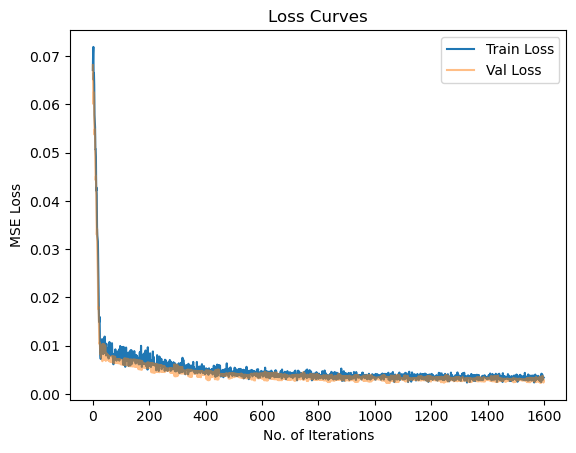

In [22]:
num = 0


print (f"Number of epochs:{epochs}, \t Train and Validation batch_size = {batch_size},\t Test batch_size = {bs}")
print("Minimum Validation Loss: ",min_val_loss, "\nMinimum Train Loss: ", min_train_loss,  "\nTest Loss: ",Test_error)
print("========================================================")
print("Learning rate: ", lr)
print(f"Time taken for Training = {round(tok-tik, 3)}s")
plt.plot(train_loss_arr[num:], label = "Train Loss", alpha = 1)
plt.plot(val_loss_arr[num:], label = "Val Loss", alpha = 0.5)
plt.legend()
plt.title("Loss Curves")
plt.xlabel("No. of Iterations")
plt.ylabel("MSE Loss")
plt.show()

# **Predicring the similarities**

In [23]:
# Predicring the similarities for the whole dataset one more time after the model is trained: 
# These similarities will be used is input for the next step (clustering)

Total_error, predicted_sim_total = evaluate(Dataset_loader , model, loss_criterion)

predicted_similarities = [j for sub in predicted_sim_total for j in sub]

Matrix_predicted_similarities = np.reshape(predicted_similarities, (60, 60))

# Part 2: Clustering the users

In [24]:
## Dominant set:

import numpy as np
from numpy.linalg import norm

def dominant_set(A, x=None, epsilon=1.0e-4):
    """Compute the dominant set of the similarity matrix A with the
    replicator dynamics optimization approach. Convergence is reached
    when x changes less than epsilon.

    See: 'Dominant Sets and Pairwise Clustering', by Massimiliano
    Pavan and Marcello Pelillo, PAMI 2007.
    """
    if x is None:
        x = np.ones(A.shape[0])/float(A.shape[0])
        
    distance = epsilon*2
    while distance > epsilon:
        x_old = x.copy()
        # x = x * np.dot(A, x) # this works only for dense A
        x = x * A.dot(x) # this works both for dense and sparse A
        x = x / x.sum()
        distance = norm(x - x_old) ## norm of a matrix is a number that estimetes how big is that matrix.
        #print (x.size, distance)

    return x


In [25]:
## DS_Clustering

"""Dominant set clustering: iteratively find the dominant set and then
remove it from the dataset.
"""

import numpy as np
import pandas as pd

if __name__ == '__main__':

    from sklearn.metrics import pairwise_distances
    from sklearn.datasets import make_blobs
    import matplotlib.pyplot as plt


    num_users=60
    
    min = np.min(Matrix_predicted_similarities)
    max = np.max(Matrix_predicted_similarities)
    sim = Matrix_predicted_similarities
    Norm_sim = ((sim-min)/(max-min))
    D =  1- Norm_sim#****** D should be distance 
    X = np.array([i for i in range(1 , num_users+1)])

    sigma2 = np.median(D)
    
    
    S = np.exp(-D / sigma2)  ## It seems that S is the similarity matrix.

    i = 0 
    labels_clusters = np.zeros(num_users)  ##**
    Groups_id=[]   ##** Saving the id of the group members.
    
    while S.size > 10:  
        i+=1
        x = dominant_set(S, epsilon=2e-4)
        cutoff = np.median(x[x>0])  ## median is the element in the middle of the sorted elements


        #**
        idx_dominant = x > cutoff
        X_dominant = X[idx_dominant]
        ## labels indicate the cluster number of that user. (0 means not clustered)
        labels_clusters[X_dominant-1] = i
        print(f"Cluster number{i} has: {X_dominant.size} users with ids: {X_dominant}")
        Groups_id.append(X_dominant)   ##**
        #**

        # remove the dominant set
        idx = x <= cutoff
        S = S[idx, :][:, idx]
        X = X[idx]
        
    print(f"User not blong to any groups are: {X}")   

 

Cluster number1 has: 30 users with ids: [ 5  8  9 17 18 21 25 26 28 31 35 36 37 38 40 41 42 43 46 47 48 50 51 52
 53 54 55 57 58 60]
Cluster number2 has: 15 users with ids: [ 1  2  6 11 13 14 19 23 24 29 30 34 45 49 59]
Cluster number3 has: 7 users with ids: [ 3 10 12 22 39 44 56]
Cluster number4 has: 4 users with ids: [ 4 15 32 33]
Cluster number5 has: 2 users with ids: [16 27]
User not blong to any groups are: [ 7 20]


In [26]:
# Saving the groups ids as a csv file:
import csv

Groups_id_2d_list = [array.tolist() for array in Groups_id]
file_path = "group_Mambers_IDs_CarData.csv"

# Write the 2D list to the CSV file
with open(file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    for row in Groups_id_2d_list:
        csv_writer.writerow(row)

print("CSV file saved successfully.")

CSV file saved successfully.


# Clustering Evaluation:

In [27]:
## The distance metric to use. The distance function can be ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, ‘kulczynski1’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.
from sklearn import metrics
X = Dataset_users.values.tolist()  # vectors of features of users 
labels = labels_clusters


metric_euc = 'euclidean'
Sil_euc = metrics.silhouette_score(X, labels, metric = metric_euc)
CH = metrics.calinski_harabasz_score(X, labels)
DB = metrics.davies_bouldin_score(X, labels)
print (f'"{metric_euc}" between the "feature vectors of the users":')
print (f"Silhouette_score = {Sil_euc},\nCalinski_harabasz_score = {CH},\nDavies_bouldin_score = {DB})\n")


"euclidean" between the "feature vectors of the users":
Silhouette_score = -0.24971771698978873,
Calinski_harabasz_score = 2.5031009534147985,
Davies_bouldin_score = 7.139337195306343)



In [28]:
## "Similarity" is "cosine":
metric_cos = 'cosine'
Sil_cos = metrics.silhouette_score(X, labels, metric = metric_cos)
print (f'"{metric_cos}" between the "feature vectors of the users":')
print (f"Silhouette_score = {Sil_cos}")

"cosine" between the "feature vectors of the users":
Silhouette_score = -0.5340002510653057


In [29]:
## "Similarity" is "GCN":
S = preprocessing.normalize(Matrix_predicted_similarities)
D =  1- S  #((S-np.min(S))/(np.max(S)-np.min(S)))  # An array of pairwise distances between samples.
np.fill_diagonal(D, 0)

Sil_GCN = metrics.silhouette_score(D, labels, metric = "precomputed")
print (f'"Similarity" is "GCN":')
print (f"Silhouette_score = {Sil_GCN }")

"Similarity" is "GCN":
Silhouette_score = -0.004603846179904911


In [30]:
## "Similarity" is "GED":
SS = []
for pg in Dataset_loader:
    SS.append(sim_GED (pg.edge_index_1, pg.edge_index_2))
    
SSS = np.reshape(SS, (60, 60))
S = preprocessing.normalize(SSS)
D =  1- S  #((S-np.min(S))/(np.max(S)-np.min(S)))  # An array of pairwise distances between samples.
np.fill_diagonal(D, 0)

Sil_GED = metrics.silhouette_score(D, labels, metric = "precomputed")
print (f'"Similarity" is "GED":')
print (f"Silhouette_score = {Sil_GED}")

"Similarity" is "GED":
Silhouette_score = -0.02868795511828158


In [31]:
## "Similarity" is "Top-K":
SS = []
for pg in Dataset_loader:
    SS.append(sim_TopK (pg.edge_index_1, pg.edge_index_2))

SSS = np.reshape(SS, (60, 60))
S = preprocessing.normalize(SSS)
D =  1- S  #((S-np.min(S))/(np.max(S)-np.min(S)))  # An array of pairwise distances between samples.
np.fill_diagonal(D, 0)

Sil_TopK = metrics.silhouette_score(D, labels, metric = "precomputed")
print (f'"Similarity" is "Top-K":')
print (f"Silhouette_score = {Sil_TopK}")

"Similarity" is "Top-K":
Silhouette_score = -0.0082220674826191


# Printing the final results:

		*********** Ground-truth for GNN: TopK ***********

Number of epochs:100, 	 Train and Validation batch_size = 128,	 Test batch_size = 128
Minimum Validation Loss:  0.0023457901552319527 
Minimum Train Loss:  0.0024738959036767483 
Test Loss:  0.0053601921536028385
Time taken for Training = 0.091s


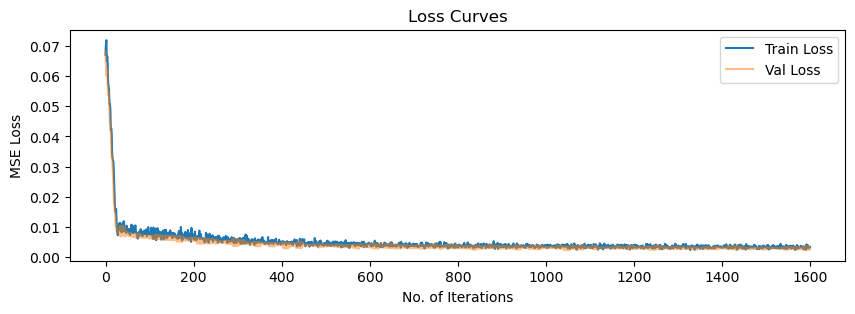

In [32]:
num = 0
"""This algorithm has two phases: 
    1. Predicting similarity between the users(pair-wise praphs) comes from GCN. (ground truth once is Top-K items and once is GCN)
    2. Clustering based the results of phase 1 using the "Dominant-set" Algorithm.
    And Finally evaluating our clustering with different metrics."""

print ("\t\t*********** Ground-truth for GNN: TopK ***********\n")
print (f"Number of epochs:{epochs}, \t Train and Validation batch_size = {batch_size},\t Test batch_size = {bs}")
print("Minimum Validation Loss: ",min_val_loss, "\nMinimum Train Loss: ", min_train_loss,  "\nTest Loss: ",Test_error)
print("========================================================")
print(f"Time taken for Training = {round(tok-tik, 3)}s")
plt.figure(figsize=(10,3))
plt.plot(train_loss_arr[num:], label = "Train Loss", alpha = 1)
plt.plot(val_loss_arr[num:], label = "Val Loss", alpha = 0.5)
plt.legend()
plt.title("Loss Curves")
plt.xlabel("No. of Iterations")
plt.ylabel("MSE Loss")
plt.show()

# print("*** Evaluation of the clustering with different metrics:***\n")

# print (f'Metric: "{metric_euc}" between the "feature vectors of the users":\t Silhouette_score = {Sil_euc}\n')

# print (f'Metric: "{metric_cos}" between the "feature vectors of the users":\t Silhouette_score = {Sil_cos}\n')

# print (f'Metric: "Similarity" is "GCN":\t\t\t\t\t Silhouette_score = {Sil_GCN}\n')

# print (f'Metric: "Similarity" is "GED":\t\t\t\t\t Silhouette_score = {Sil_GED}\n')

# print (f'Metric: "Similarity" is "Top-K":\t\t\t\t Silhouette_score = {Sil_TopK}\n')

# print(f"Calinski_harabasz_score = {CH},\nDavies_bouldin_score = {DB})\n")

# Recommending itams to groups of users

In [33]:
## AGGRIGATION METHODS: We defined different methods here:

# Item_scores_matrix is a matrix which rows are users and columns are items. Entries indicte how much the user likes this item more than the other items.
# Please see section **Similarity** where we defined it.
# Personalized_Item_scores_matrix is the normalized Item_scores_matrix

## 1. Average 
def Agg_Average (Personalized_Item_scores_matrix, Groups_id, num_items):  
    Groups_Item_score = np.zeros ((len(Groups_id), num_items))
    for group_num in range(len(Groups_id)):
        for user in Groups_id[group_num]:
            for item in range(num_items):
                Groups_Item_score[group_num][item] += Personalized_Item_scores_matrix[user-1][item]
        Groups_Item_score[group_num] /= len(Groups_id[group_num])
    return Groups_Item_score

    
## 2. Approval Voting     
def Agg_ApprovalVoting (Personalized_Item_scores_matrix, Groups_id, num_items):  
    Groups_Item_score = np.zeros ((len(Groups_id), num_items))
    threshold = 0.4
    for group_num in range(len(Groups_id)):
        for item in range(num_items):
            votes = 0
            for user in Groups_id[group_num]:
                if Personalized_Item_scores_matrix[user-1][item] >= threshold:
                    votes += 1
                    #print("group_num",group_num, "item", item, "user", user)
            Groups_Item_score[group_num][item] =  votes
    return Groups_Item_score
    

gn = 0



# ***EVALUATION: ***

# Confusion Matrix

In [34]:
def plot_confusion_matrix(tp, fp, tn, fn, classes, Teta, F1_score):
    # Create confusion matrix data
    cm = np.array([[tn, fp], [fn, tp]])

    # Create figure and axis
    fig, ax = plt.subplots()

    # Create heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=15)


    # Set tick labels and axis labels
    #ax.set(xticks=np.arange(cm.shape[1]),yticks=np.arange(cm.shape[0])),xticklabels=classes, yticklabels=classes),xlabel='Predicted', ylabel='Ground truth')
    ax.set_xticks (np.arange(cm.shape[1])) 
    ax.set_yticks (np.arange(cm.shape[0]))
    ax.set_xticklabels (classes, fontsize=25)  
    ax.set_yticklabels (classes, fontsize=25) 
    ax.set_xlabel('Predicted', fontsize=25)
    ax.set_ylabel('Ground truth', fontsize=25)

    # Loop over data dimensions and add text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center', color='black', fontsize=20)

    # Show plot
    Title = "Teta:{}    F1_score:{}".format(Teta, F1_score)
    plt.title(Title, fontsize=25)
    plt.tight_layout()
    plt.show()


Group_NEWFairness_total: 1.0


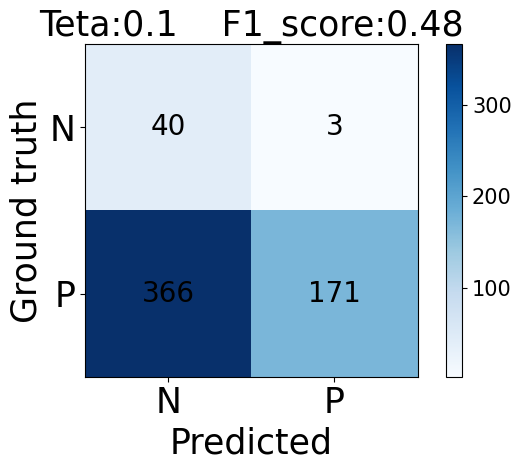

Teta: 0.1 	 F1_score: 0.48
SumTP 171 SumFP 3 SumTN 40 SumFN 366
Group_NEWFairness_total: 0.9866666666666667


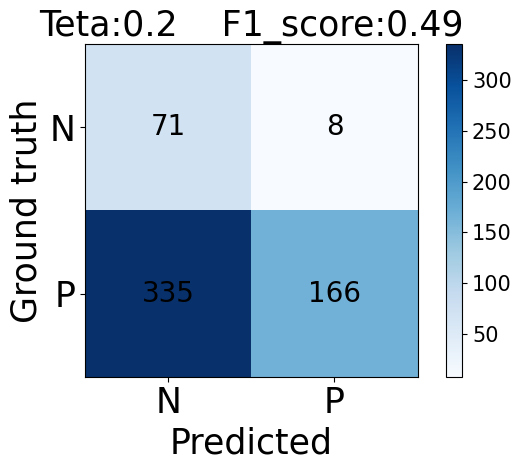

Teta: 0.2 	 F1_score: 0.49
SumTP 166 SumFP 8 SumTN 71 SumFN 335
Group_NEWFairness_total: 0.9400000000000001


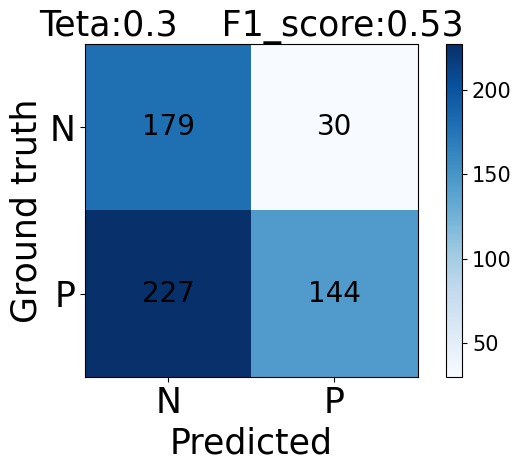

Teta: 0.3 	 F1_score: 0.53
SumTP 144 SumFP 30 SumTN 179 SumFN 227
Group_NEWFairness_total: 0.9400000000000001


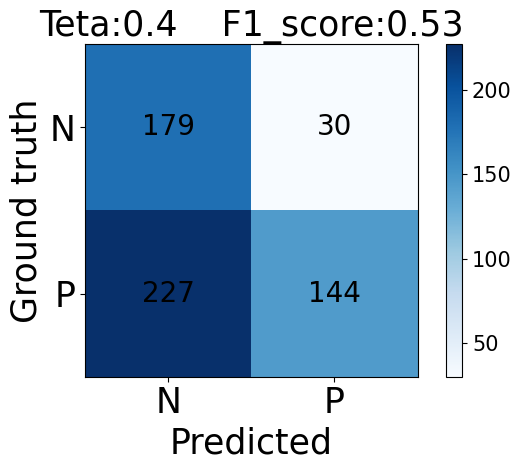

Teta: 0.4 	 F1_score: 0.53
SumTP 144 SumFP 30 SumTN 179 SumFN 227
Group_NEWFairness_total: 0.8780952380952382


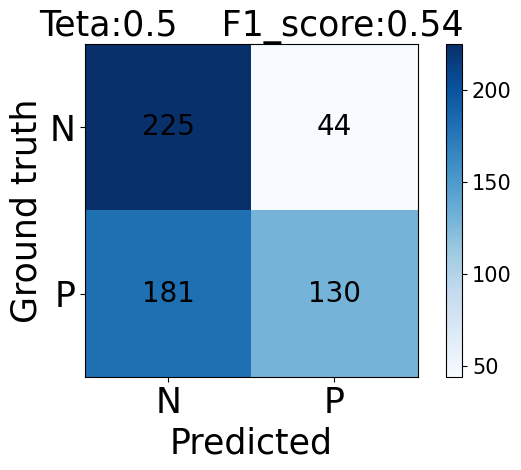

Teta: 0.5 	 F1_score: 0.54
SumTP 130 SumFP 44 SumTN 225 SumFN 181
Group_NEWFairness_total: 0.7357142857142858


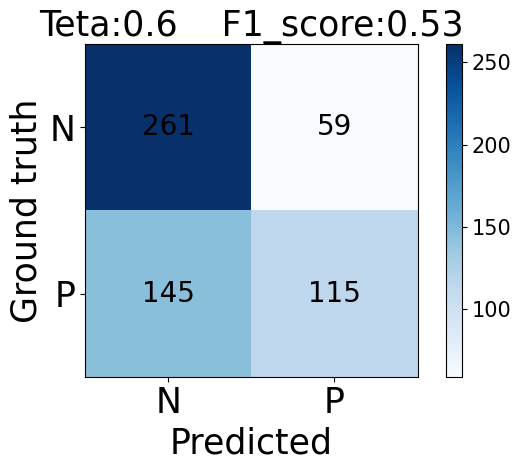

Teta: 0.6 	 F1_score: 0.53
SumTP 115 SumFP 59 SumTN 261 SumFN 145
Group_NEWFairness_total: 0.2733333333333333


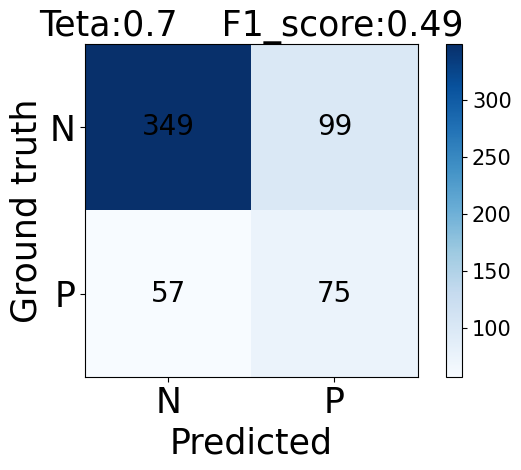

Teta: 0.7 	 F1_score: 0.49
SumTP 75 SumFP 99 SumTN 349 SumFN 57
Group_NEWFairness_total: 0.2733333333333333


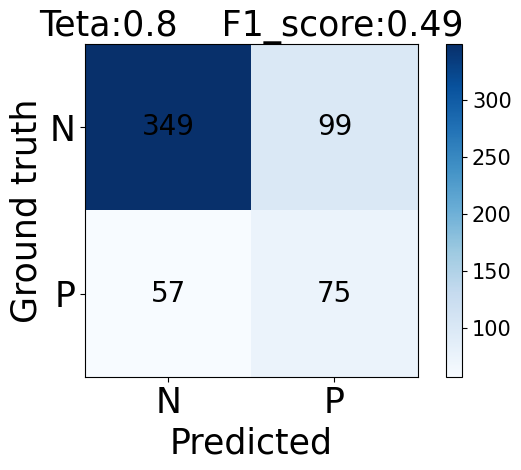

Teta: 0.8 	 F1_score: 0.49
SumTP 75 SumFP 99 SumTN 349 SumFN 57
Group_NEWFairness_total: 0.17333333333333334


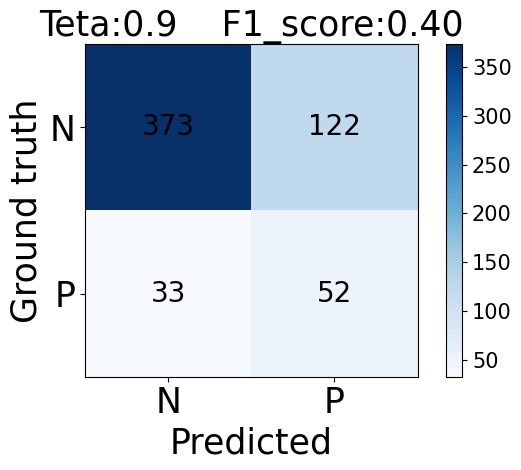

Teta: 0.9 	 F1_score: 0.40
SumTP 52 SumFP 122 SumTN 373 SumFN 33
Program Executed in 2.149904689998948


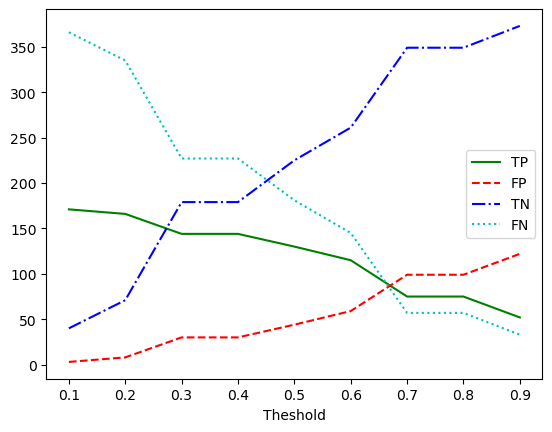

[0.4810126582278481, 0.4918518518518518, 0.528440366972477, 0.528440366972477, 0.5360824742268041, 0.5299539170506913, 0.4901960784313726, 0.4901960784313726, 0.4015444015444015]


In [35]:
# Evaluation (This evaluation ok: "based on my definition of TP, FP, T.")
start = timeit.default_timer()
#
ground_truth = Personalized_Item_scores_matrix
num_groups = len(Groups_id)
# Choose the aggregation method:
Groups_Item_score = Agg_Average (Personalized_Item_scores_matrix, Groups_id, num_items)
#Groups_Item_score = Agg_ApprovalVoting (Personalized_Item_scores_matrix, Groups_id, num_items)
Theshold = np.arange(0.1, 1.0, 0.1)
Precision_list = []
Recall_list = []
F1_score_list = []
Group_NEWFairness_total_list = []
SumTP_list = []   #sum of True Positive
SumFP_list = []   #sum of False Positive
SumTN_list = []   #sum of True Negative
SumFN_list = []   #sum of False Negative
for  Teta in Theshold:
    SumTP = 0   #sum of True Positive
    SumFP = 0   #sum of False Positive
    SumTN = 0   #sum of True Negative
    SumFN = 0   #sum of False Negative
    SumT = 0
    SumGroup_Fairness = 0
    SumGroup_NEWFairness = 0

    for group_num in range(0,num_groups): #********************
        num_groupMembers = len(Groups_id[group_num])
        TP=0  # TP: True Positive
        FP=0  # FP: False positive
        TN=0  # TN: true Negative
        FN=0  # FN: False Negative
        T=0  # T: expected recommendations sets
        Group_Fairness = 0
        TopK = 3 # number of recommended items  
        Recommended_items = np.flip(np.argsort(Groups_Item_score[group_num]))[0:TopK]  # set of "RECOMMENDED item for that group"  (Positive items)
        #print("Recommended items for group", group_num+1 ,"are: ", Recommended_items)

        # Calculating "Precision" and "Recall" ***********************
        for item in range(num_items):
            if item in Recommended_items:
                # TP: True Positive: These are the items that the system correctly suggests and that the user finds relevant or useful.
                for user in Groups_id[group_num]:
                    if ground_truth[user-1][item] >= Teta:  # positive item 
                        TP+=1  
                    else:
                        # FP: False positive: These are the items that the system suggests, but the user does not find relevant or useful.
                        FP+=1
            else:
                # TN: True Negative: These are the items that the system correctly does not suggest, as they are not relevant or useful to the user.
                # FN: False Negative: These are the items that the system does not suggest, but the user would have found relevant or useful. These represent missed opportunities.
                for user in Groups_id[group_num]:
                    if ground_truth[user-1][item] >= Teta:  # positive item 
                        FN+=1  
                    else:
                        TN+=1
        # T: Expected recommendations set
            for user in Groups_id[group_num]:
                if ground_truth[user-1][item] >= Teta:
                    T+=1

        Precision=TP/(TP+FP)
        #print("Precision:", Precision)
        Recall=TP/T
        #print("Recall:", Recall)   
        SumTP += TP
        SumFP += FP
        SumTN += TN
        SumFN += FN
        SumT += T


        # Calculating "Fairness" ***********************
        # Fairness indicate how much a recommended item is Fair. i.e. (number of group members like the recommended item)/(All group members)
        Sum_Fairness = 0
        for item in Recommended_items: # set of "RECOMMENDED item for that group"  
                Satisfied_User = 0
                for user in Groups_id[group_num]:
                    if ground_truth[user-1][item] >= Teta: 
                        Satisfied_User += 1
                Fairness = Satisfied_User/ num_groupMembers
                Sum_Fairness += Fairness
        Group_Fairness = Sum_Fairness / len(Recommended_items)   
        #print ("Group Fairness:", Group_Fairness) 
        SumGroup_Fairness += Group_Fairness 


        # Calculating "NEWFairness" ***********************
        # NEWFairness is defined as the share of group members ui with at least m items in the recommended package for which ui has a high performance.
        SatisfiedMembers = 0
        Threshold = Teta
        Sum_NEWFairness = 0
        for user in Groups_id[group_num]:
            F = 0
            for item in Recommended_items:
                if ground_truth[user-1][item] >= Threshold: 
                    F += 1
            if F > len(Recommended_items)/2:
                SatisfiedMembers += 1
        Group_NEWFairness = SatisfiedMembers /num_groupMembers
        #print ("Group NEWFairness:", Group_NEWFairness, "\n") 
        SumGroup_NEWFairness += Group_NEWFairness        


        # Calculating "Consensus" ***********************
        Sum_Item_Consensus = 0
        for item in Recommended_items: # set of "RECOMMENDED item for that group"  
            error = 0
            for user in Groups_id[group_num]:   
                for user2 in Groups_id[group_num]: 
                    error += abs(ground_truth[user-1][item] - ground_truth[user2-1][item])
            Item_Consensus =  1 - error / (num_groupMembers * (num_groupMembers -1) / 2 * np.max(ground_truth))
            Sum_Item_Consensus += Item_Consensus
        Group_Consensus =   Sum_Item_Consensus/ len(Recommended_items)
        #print ("Group Consensus:", Group_Consensus, "\n") 
    

    SumTP_list.append(SumTP)
    SumFP_list.append(SumFP) 
    SumTN_list.append(SumTN)
    SumFN_list.append(SumFN)
    
#     print("****************************")  
#    print("Teta:", Teta)
    Precision_total=SumTP/(SumTP+SumFP)
#     print("Precision_total:", Precision_total)
    Recall_total=SumTP/SumT
#     print("Recall_total:", Recall_total)  
    F1_score = 2 * Precision_total * Recall_total / (Precision_total + Recall_total)
#   print("F1-score:", F1_score) 
#     Group_Fairness_total = SumGroup_Fairness / len(Groups_id)
#     #print("Group_Fairness_total:", Group_Fairness_total)
    Group_NEWFairness_total = SumGroup_NEWFairness / num_groups
    print("Group_NEWFairness_total:", Group_NEWFairness_total)
#     print("****************************")   

    # Plot confusion matrix
    classes = ['N', 'P']
    plot_confusion_matrix(SumTP, SumFP, SumTN, SumFN, classes, format(Teta, '.1f'), format(F1_score, '.2f'))
    print("Teta:", format(Teta, '.1f'),"\t", "F1_score:", format(F1_score, '.2f'))
    print("SumTP",SumTP,"SumFP", SumFP, "SumTN",SumTN,"SumFN", SumFN)
    
    
    Precision_list.append(Precision_total)
    Recall_list.append(Recall_total)
    F1_score_list.append(F1_score)
    Group_NEWFairness_total_list.append(Group_NEWFairness_total)

    
stop = timeit.default_timer()
execution_time = stop - start
print("Program Executed in "+str(execution_time)) # It returns time in seconds


plt.plot(Theshold, SumTP_list, '-g', label = 'TP')
plt.plot(Theshold, SumFP_list, '--r', label = 'FP')
plt.plot(Theshold, SumTN_list, '-.b', label = 'TN')
plt.plot(Theshold, SumFN_list, ':c', label = 'FN')
plt.legend()
plt.xlabel('Theshold')
plt.ylabel('')
plt.title('')
plt.show()
print(F1_score_list)

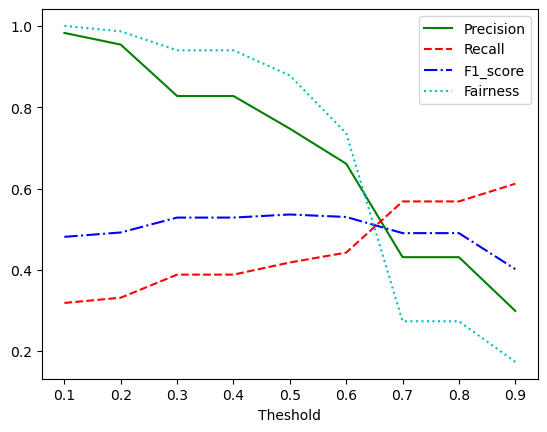

In [36]:
plt.plot(Theshold, Precision_list, '-g', label = 'Precision')
plt.plot(Theshold, Recall_list, '--r', label = 'Recall')
plt.plot(Theshold, F1_score_list, '-.b', label = 'F1_score')
plt.plot(Theshold, Group_NEWFairness_total_list, ':c', label = 'Fairness')
plt.legend()
plt.xlabel('Theshold')
plt.ylabel('')
plt.title('')
plt.show()

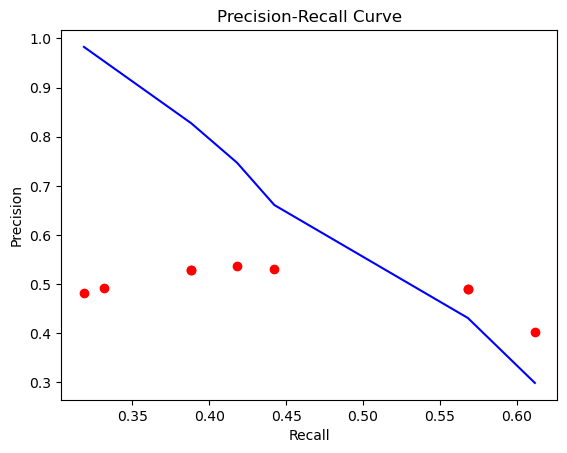

In [37]:
plt.plot(Recall_list, Precision_list, 'b')
plt.plot(Recall_list, F1_score_list, 'or')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Experiment with random groups (compared to groups of clusters) 

In [38]:
# Evaluation (This evaluation ok: "based on my definition of TP, FP, T.")
start = timeit.default_timer()
#
Clustered_Groups_id = Groups_id
ground_truth = Personalized_Item_scores_matrix
# Choose the aggregation method:
Groups_Item_score = Agg_Average (Personalized_Item_scores_matrix, Groups_id, num_items)
#Groups_Item_score = Agg_ApprovalVoting (Personalized_Item_scores_matrix, Groups_id, num_items)
num_groups = len(Clustered_Groups_id) #equal to the number of clusters
Theshold = np.arange(0.2, 1.0, 0.1)
Precision_list2 = []
Recall_list2 = []
F1_score_list2 = []
Group_NEWFairness_total_list2 = []
for  Teta in Theshold:
    SumTP = 0   #sum of True Positive
    SumFP = 0   #sum of False Positive
    SumT = 0
    SumGroup_Fairness = 0
    SumGroup_NEWFairness = 0
    
    # Shuffle the numbers between
    numbers = list(range(0, num_users-1))
    random.shuffle(numbers)
    Groups_id = []
    start_index = 0
    for group_num in range(0,num_groups): #********************
        # We generate random groups the same size as the clustered groups:
        num_groupMembers = len(Clustered_Groups_id[group_num])
#        Groups_id.append(np.random.randint(1,21,num_groupMembers))  #Generating random members for each group
        Groups_id.append(numbers[start_index:start_index+num_groupMembers])
        start_index += num_groupMembers
#        Groups_Item_score = Agg_ApprovalVoting (Personalized_Item_scores_matrix, Groups_id, num_items)
        Groups_Item_score = Agg_Average (Personalized_Item_scores_matrix, Groups_id, num_items)
#        print("group_num, num_groupMembers, Groups_id: ", group_num, num_groupMembers, Groups_id)

        TP=0  # TP: True Positive
        FP=0  # FP: False positive
        T=0  # T: expected recommendations sets
        Group_Fairness = 0
        #Teta= 0.4  # Theshold   
        TopK = 3 # number of recommended items
        Recommended_items = np.flip(np.argsort(Groups_Item_score[group_num]))[0:TopK]  # set of "RECOMMENDED item for that group"  (Positive items)
        #print("Recommended items for group", group_num+1 ,"are: ", Recommended_items)

        # Calculating "Precision" and "Recall" ***********************
        for item in Recommended_items:
            # TP: True Positive
            for user in Groups_id[group_num]:
                #print (user-1,item,ground_truth[user-1][item])
                if ground_truth[user-1][item] >= Teta:  # positive item 
                    TP+=1
                    #print("group_num",group_num, "item", item, "user", user, "TP", TP)    
                else:
                    # FP: False positive
                    FP+=1
        # T: Expected recommendations set
        for item in range(num_items):
            for user in Groups_id[group_num]:
                if ground_truth[user-1][item] >= Teta:
                    T+=1

        Precision=TP/(TP+FP)
        #pint("Precision:", Precision)
        Recall=TP/T
       #print("Recall:", Recall)   
        SumTP += TP
        SumFP += FP
        SumT += T


        # Calculating "Fairness" ***********************
        # Fairness indicate how much a recommended item is Fair. i.e. (number of group members like the recommended item)/(All group members)
        Sum_Fairness = 0
        for item in Recommended_items: # set of "RECOMMENDED item for that group"  
                Satisfied_User = 0
                for user in Groups_id[group_num]:
                    if ground_truth[user-1][item] >= Teta: 
                        Satisfied_User += 1
                Fairness = Satisfied_User/ num_groupMembers
                Sum_Fairness += Fairness
        Group_Fairness = Sum_Fairness / len(Recommended_items)   
      # print ("Group Fairness:", Group_Fairness) 
        SumGroup_Fairness += Group_Fairness 


        # Calculating "NEWFairness" ***********************
        # NEWFairness is defined as the share of group members ui with at least m items in the recommended package for which ui has a high performance.
        SatisfiedMembers = 0
        Threshold = Teta
        Sum_NEWFairness = 0
        for user in Groups_id[group_num]:
            F = 0
            for item in Recommended_items:
                if ground_truth[user-1][item] >= Threshold: 
                    F += 1
            if F > len(Recommended_items)/2:
                SatisfiedMembers += 1
        Group_NEWFairness = SatisfiedMembers /num_groupMembers
      # print ("Group NEWFairness:", Group_NEWFairness, "\n") 
        SumGroup_NEWFairness += Group_NEWFairness        


        # Calculating "Consensus" ***********************
        Sum_Item_Consensus = 0
        for item in Recommended_items: # set of "RECOMMENDED item for that group"  
            error = 0
            for user in Groups_id[group_num]:   
                for user2 in Groups_id[group_num]: 
                    error += abs(ground_truth[user-1][item] - ground_truth[user2-1][item])
            Item_Consensus =  1 - error / (num_groupMembers * (num_groupMembers -1) / 2 * np.max(ground_truth))
            Sum_Item_Consensus += Item_Consensus
        Group_Consensus =   Sum_Item_Consensus/ len(Recommended_items)
        #print ("Group Consensus:", Group_Consensus, "\n") 

    print("****************************")  
    print("Teta:", Teta)
    Precision_total=SumTP/(SumTP+SumFP)
    print("Precision_total:", Precision_total)
    Recall_total=SumTP/SumT
    print("Recall_total:", Recall_total)  
    F1_score = 2 * Precision_total * Recall_total / (Precision_total + Recall_total)
    print("F1-score:", F1_score) 
    Group_Fairness_total = SumGroup_Fairness / len(Groups_id)
    #print("Group_Fairness_total:", Group_Fairness_total)
    Group_NEWFairness_total = SumGroup_NEWFairness / num_groups
    print("Group_NEWFairness_total:", Group_NEWFairness_total)
    print("****************************")   


    Precision_list2.append(Precision_total)
    Recall_list2.append(Recall_total)
    F1_score_list2.append(F1_score)
    Group_NEWFairness_total_list2.append(Group_NEWFairness_total)
    
stop = timeit.default_timer()
execution_time = stop - start
print("Program Executed in "+str(execution_time)) # It returns time in seconds




****************************
Teta: 0.2
Precision_total: 0.9425287356321839
Recall_total: 0.3273453093812375
F1-score: 0.48592592592592593
Group_NEWFairness_total: 0.9933333333333334
****************************
****************************
Teta: 0.30000000000000004
Precision_total: 0.8563218390804598
Recall_total: 0.4027027027027027
F1-score: 0.5477941176470589
Group_NEWFairness_total: 0.9666666666666668
****************************
****************************
Teta: 0.4000000000000001
Precision_total: 0.7298850574712644
Recall_total: 0.4057507987220447
F1-score: 0.5215605749486654
Group_NEWFairness_total: 0.8961904761904762
****************************
****************************
Teta: 0.5000000000000001
Precision_total: 0.6724137931034483
Recall_total: 0.45
F1-score: 0.5391705069124424
Group_NEWFairness_total: 0.8209523809523809
****************************
****************************
Teta: 0.6000000000000001
Precision_total: 0.5459770114942529
Recall_total: 0.4797979797979798
F1-s

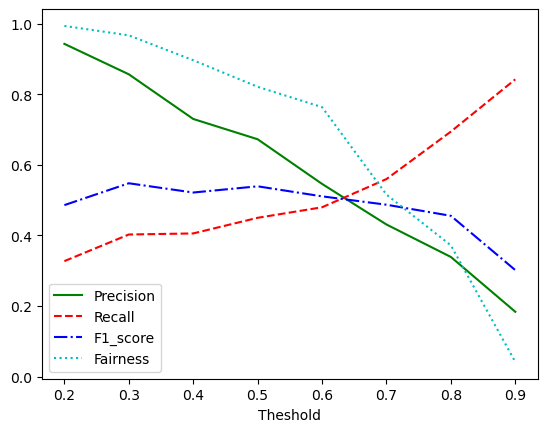

In [39]:
plt.plot(Theshold, Precision_list2, '-g', label = 'Precision')
plt.plot(Theshold, Recall_list2, '--r', label = 'Recall')
plt.plot(Theshold, F1_score_list2, '-.b', label = 'F1_score')
plt.plot(Theshold, Group_NEWFairness_total_list2, ':c', label = 'Fairness')
plt.legend()
plt.xlabel('Theshold')
plt.ylabel('')
plt.title('')
plt.show()

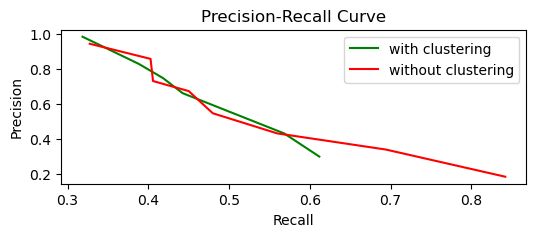

In [40]:
plt.figure(figsize=(6,2))
plt.plot(Recall_list, Precision_list, 'g', label = 'with clustering')
plt.plot(Recall_list2, Precision_list2, 'r', label = 'without clustering')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()